In [1]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [4]:
from sklearn.metrics import mean_squared_error
from skimage.measure import compare_ssim
from math import sqrt
import numpy as np
import time, os, random
from keras.callbacks import TensorBoard
%matplotlib inline
import matplotlib.pyplot as plt
from keras.callbacks import History

from keras.datasets import mnist
from keras_contrib.layers.normalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, GaussianNoise
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers import Concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras import losses
from keras.utils import to_categorical
import keras.backend as K
import scipy
import pandas as pd

import matplotlib.pyplot as plt

import numpy as np
from sklearn.model_selection import train_test_split
from pprint import pprint
EXECUTION_TIME = time.strftime("%Y%m%d-%H%M%S")

Using TensorFlow backend.


In [3]:
def mask_randomly(imgs, mask_height, mask_width, img_rows):
    y1 = np.random.randint(0, imgs.shape[1] - mask_height, imgs.shape[0])
    y2 = y1 + mask_height
    x1 = np.random.randint(0, imgs.shape[2] - mask_width, imgs.shape[0])
    x2 = x1 + mask_width
    
    masked_imgs = np.empty_like(imgs)
    for i, img in enumerate(imgs):
        masked_img = img.copy()
        _y1, _y2, _x1, _x2 = y1[i], y2[i], x1[i], x2[i],
        masked_img[_y1:_y2, _x1:_x2] = 0
        masked_imgs[i] = masked_img
    return masked_imgs, y1, x1

def mask_same(imgs, mask_height, mask_width, x, y):    
    y1 = y
    y2 = y1 + mask_height
    x1 = x
    x2 = x1 + mask_width
    masked_imgs = np.empty_like(imgs)
    for i, img in enumerate(imgs):
        masked_img = img.copy()
        _y1, _y2, _x1, _x2 = y1[i], y2[i], x1[i], x2[i],
        masked_img[_y1:_y2, _x1:_x2] = 0
        masked_imgs[i] = masked_img
    return masked_imgs

def cut(img, idx_x, idx_y, height, width):
    return img[idx_y : idx_y+height, idx_x : idx_x+width, 0]

def masked_area_score(model,X):
    masked_data, idx_y, idx_x = mask_randomly(X, model.mask_height, model.mask_width, model.img_rows)
    predicted_data = model.generator.predict(masked_data)
    to_be_evaluated = [(cut(original,mask_x,mask_y,model.mask_height,model.mask_width), cut(pred,mask_x,mask_y,model.mask_height,model.mask_width)) for original,pred,mask_x,mask_y in zip(X,predicted_data,idx_x,idx_y)]
    mse = np.average([mean_squared_error(img_true,img_predict) for img_true,img_predict in to_be_evaluated])
    ssim = np.average([compare_ssim(img_true, img_predict) for img_true,img_predict in to_be_evaluated])
    return mse, ssim

def whole_image_score(model, X):
    masked_data, idx_y, idx_x = mask_randomly(X, model.mask_height, model.mask_width, model.img_rows)
    predicted_data = model.generator.predict(masked_data)
    mse = np.average([mean_squared_error(img_true[...,0], img_predict[...,0]) for img_true,img_predict in zip(X, predicted_data)])
    ssim = np.average([compare_ssim(img_true[...,0], img_predict[...,0]) for img_true,img_predict in zip(X, predicted_data)])
    return mse, ssim

def outside_area_score(model,X):
    masked_data, idx_y, idx_x = mask_randomly(X, model.mask_height, model.mask_width, model.img_rows)
    predicted_data = model.generator.predict(masked_data)
    predicted_masked_data = mask_same(predicted_data, model.mask_height, model.mask_width, idx_y, idx_x)
    mse = np.average([mean_squared_error(img_true[...,0], img_predict[...,0]) for img_true,img_predict in zip(X, predicted_data)])
    ssim = np.average([compare_ssim(img_true[...,0], img_predict[...,0]) for img_true,img_predict in zip(X, predicted_data)])
    return mse, ssim


In [4]:
from collections import defaultdict
class CCGAN(object):
    def __init__(self, img_rows, img_cols, mask_height, mask_width, learn_rate, beta_1): #constructor
        self.img_rows = img_rows#176#32 176x144
        self.img_cols = img_cols #144#32 #property
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.mask_height = mask_height#50
        self.mask_width = mask_width #50
        self.num_classes = 45#10
        self.d_loss = {}
        self.g_loss = {}
        self.scores = defaultdict(dict)
        
        # Number of filters in first layer of generator and discriminator
        self.gf = 32
        self.df = 32
        self.learn_rate=learn_rate
        self.beta_1 = beta_1
        optimizer = Adam(self.learn_rate, self.beta_1) #learning_rate 0.0002, adam_beat_1 0.5

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=['mse', 'binary_crossentropy'],
            loss_weights=[0.5, 0.5],
            optimizer=optimizer,
            metrics=['accuracy']) #categorical_crossentropy

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise?!?! as input and generates imgs
        masked_img = Input(shape=self.img_shape) #Input instantiate a keras tensor
        gen_img = self.generator(masked_img)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The valid takes generated images as input and determines validity
        valid, _ = self.discriminator(gen_img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(masked_img , valid)
        self.combined.compile(loss=['mse'],
            optimizer=optimizer)
        os.makedirs(self.folder_name())#, ignore_errors=True) # CHECK
    

    def build_generator(self): #method
        """U-Net Generator"""

        def conv2d(layer_input, filters, f_size=4, bn=True):
            """Layers used during downsampling"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if bn:
                d = BatchNormalization(momentum=0.8)(d)
            return d

        def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
            """Layers used during upsampling"""
            u = UpSampling2D(size=2)(layer_input)
            u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
            if dropout_rate:
                u = Dropout(dropout_rate)(u)
            u = BatchNormalization(momentum=0.8)(u)
            u = Concatenate()([u, skip_input])
            return u

        img = Input(shape=self.img_shape)

        # Downsampling
        d1 = conv2d(img, self.gf, bn=False)
        d2 = conv2d(d1, self.gf*2)
        mid = Cteonv2D(64, kernel_size=4, strides=1, padding='same')(d2)
        mid_leaky = LeakyReLU(alpha=0.2)(mid)
        d3 = conv2d(mid_leaky, self.gf*8)
        d4 = conv2d(d3, self.gf*16)

        # Upsampling
        u1 = deconv2d(d4, d3, self.gf*8)
        oth = Conv2D(64, kernel_size=4,strides=1, padding='same')(u1)
        oth_leaky = BatchNormalization(momentum=0.8)(oth)
        u2 = deconv2d(oth_leaky, d2, self.gf*2)
        u3 = deconv2d(u2, d1, self.gf)

        u4 = UpSampling2D(size=2)(u3)
        output_img = Conv2D(self.channels, kernel_size=4, strides=1, padding='same', activation='sigmoid')(u4) #tanh
        
        return Model(img, output_img)

    def build_discriminator(self):

        img = Input(shape=self.img_shape)

        model = Sequential()
        model.add(Conv2D(64, kernel_size=4, strides=2, padding='same', input_shape=self.img_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(128, kernel_size=6, strides=1, padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(128, kernel_size=4, strides=2, padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(InstanceNormalization())
        #model.add(BatchNormalization(momentum=0.8))
        
        model.add(Conv2D(256, kernel_size=4, strides=2, padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(InstanceNormalization())
        #model.add(BatchNormalization(momentum=0.8))

        #model.summary()

        img = Input(shape=self.img_shape)
        features = model(img)

        validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(features)

        label = Flatten()(features)
        label = Dense(self.num_classes+1, activation="softmax")(label)

        return Model(img, [validity, label])

    def mask_randomly(self, imgs):
        y1 = np.random.randint(0, self.img_rows - self.mask_height, imgs.shape[0])
        y2 = y1 + self.mask_height
        x1 = np.random.randint(0, self.img_cols - self.mask_width, imgs.shape[0])
        x2 = x1 + self.mask_width

        masked_imgs = np.empty_like(imgs)
        for i, img in enumerate(imgs):
            masked_img = img.copy()
            _y1, _y2, _x1, _x2 = y1[i], y2[i], x1[i], x2[i],
            masked_img[_y1:_y2, _x1:_x2, :] = 0
            masked_imgs[i] = masked_img

        return masked_imgs


    def train(self, X_train, epochs, batch_size, sample_interval):
        
        y_train = np.ones(len(X_train))
        # Adversarial ground truths
        valid = np.ones((batch_size, int(self.img_rows/8), int(self.img_cols/8), 1)) #* random.uniform(0.7, 1.2)
        fake = np.zeros((batch_size, int(self.img_rows/8), int(self.img_cols/8), 1)) #* random.uniform(0, 0.3)

        for epoch in range(epochs):
            # Sample half batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]
            labels = y_train[idx]

            masked_imgs = self.mask_randomly(imgs)

            # Generate a half batch of new images
            gen_imgs = self.generator.predict(masked_imgs)

            # One-hot encoding of labels
            labels = to_categorical(labels, num_classes=self.num_classes+1)
            fake_labels = to_categorical(np.full((batch_size, 1), self.num_classes), num_classes=self.num_classes+1)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, [valid, labels])
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, [fake, fake_labels])
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            #  Train Generator

            g_loss = self.combined.train_on_batch(masked_imgs, valid)

            # Plot the progress
            if epoch % (10*sample_interval) == 0:
                print ("%d [D loss: %f, op_acc: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[4], g_loss))
            if epoch % sample_interval == 0:
                self.scores['d_loss'][epoch] = d_loss[0]
                self.scores['g_loss'][epoch] = g_loss
            if epoch % (10*sample_interval) == 0:
                own_scores = self.evaluate(self.scorers)
                for key,value in own_scores.items():
                    self.scores[key][epoch]=value
            
            # If at save interval => save generated image samples
            #if epoch % sample_interval == 0:
                # Select a random half batch of images

    
    
    def sample_images(self, imgs, folder_name):
        r, c = 3, 6

        masked_imgs = self.mask_randomly(imgs)
        gen_imgs = self.generator.predict(masked_imgs)

        imgs = (imgs + 1.0) * 0.5
        masked_imgs = (masked_imgs + 1.0) * 0.5
        gen_imgs = (gen_imgs + 1.0) * 0.5

        gen_imgs = np.where(gen_imgs < 0, 0, gen_imgs)

        fig, axs = plt.subplots(r, c)
        for i in range(c):
            axs[0,i].imshow(imgs[i, :, :, 0], cmap='gray')
            axs[0,i].axis('off')
            axs[1,i].imshow(masked_imgs[i, :, :, 0], cmap='gray')
            axs[1,i].axis('off')
            axs[2,i].imshow(gen_imgs[i, :, :, 0], cmap='gray')
            axs[2,i].axis('off')
        try:
            fig.savefig("{}/final.png".format(folder_name))
        except Exception as e:
            print("Couldn't save images because of {e}".format(e=e))
        finally:
            plt.close()

    def save_model(self,folder_name):

        def save(model, model_name):
            model_path = "{}/{}.json".format(folder_name, model_name)
            weights_path = "{}/{}_weights.hdf5".format(folder_name, model_name)
            options = {"file_arch": model_path,
                        "file_weight": weights_path}
            json_string = model.to_json()
            open(options['file_arch'], 'w').write(json_string)
            model.save_weights(options['file_weight'])

        save(self.generator, "ccgan_generator")
        save(self.discriminator, "ccgan_discriminator")
    @staticmethod
    def load_model(folder_name):
        from keras.models import model_from_json
        discriminator = model_from_json(open("{}/ccgan_discriminator.json".format(folder_name)).read())
        discriminator.load_weights("{}/ccgan_discriminator_weights.hdf5".format(folder_name))
        generator = model_from_json(open("{}/ccgan_generator.json".format(folder_name)).read())
        generator.load_weights("{}/ccgan_generator_weights.hdf5".format(folder_name))
        c = CCGAN()
        c.discriminator = discriminator
        c.generator = generator
        return c
    def save_losses(self):
        for key in self.scores:
            pd.Series(self.scores[key]).to_csv('{}/{}.csv'.format(self.folder_name(),key))
        
    # Model has .train,.sample_images,.save_model
    def train_this(self, X_low_dim, epochs):
        X = np.expand_dims(X_low_dim, axis=3)
        X_train, X_test = train_test_split(X)
        self.X_test_ = X_test
        start_time = time.clock()
        self.train(X_train,epochs,batch_size=32, sample_interval=1)
        idx = np.random.randint(0, X_train.shape[0], 6)
        imgs = X_train[idx]
        self.sample_images(imgs,self.folder_name())
        self.save_model(self.folder_name())
        print(time.clock() - start_time, "seconds")
    
    def evaluate(self, scorers):
        score = {scorer.__name__ : scorer(self, self.X_test_) for scorer in scorers}
        return score
        
    
    def folder_name(self):
        model_name = str(self).replace(' ','_')
        
        return 'experiments/{}/{}'.format(EXECUTION_TIME,model_name)
    
    def __repr__(self):
        return "{}(learn_rate={}, beta_1={}, **config)".format(self.__class__.__name__,self.learn_rate,self.beta_1)

In [ ]:
class SoftLabelGAN(CCGAN):
    def train(self, X_train, epochs, batch_size, sample_interval=50):
        
        y_train = np.ones(len(X_train))

        # Adversarial ground truths
    ############################################-> turn on and off (ture/false)
        valid = np.random.uniform(0.7, 1.2, size=(batch_size, int(self.img_rows/8), int(self.img_cols/8), 1))
        fake = np.random.uniform(0, 0.3, size=(batch_size, int(self.img_rows/8), int(self.img_cols/8), 1))

        for epoch in range(epochs):
            # Sample half batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]
            labels = y_train[idx]

            masked_imgs = self.mask_randomly(imgs)

            # Generate a half batch of new images
            gen_imgs = self.generator.predict(masked_imgs)

            # One-hot encoding of labels
            labels = to_categorical(labels, num_classes=self.num_classes+1)
            fake_labels = to_categorical(np.full((batch_size, 1), self.num_classes), num_classes=self.num_classes+1)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, [valid, labels])
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, [fake, fake_labels])
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            #  Train Generator
            g_loss = self.combined.train_on_batch(masked_imgs, valid)

            # Plot the progress
            if epoch % (10*sample_interval) == 0:
                print ("%d [D loss: %f, op_acc: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[4], g_loss))
            if epoch % sample_interval == 0:
                self.d_loss[epoch] = d_loss[0]
                self.g_loss[epoch] = g_loss

In [ ]:
class DropoutGAN(CCGAN):
    def build_generator(self): #method
        """U-Net Generator"""

        def conv2d(layer_input, filters, f_size=4, bn=True):
            """Layers used during downsampling"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if bn:
                d = BatchNormalization(momentum=0.8)(d)
            return d

        def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0.2):
            """Layers used during upsampling"""
            u = UpSampling2D(size=2)(layer_input)
            u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
            if dropout_rate:
                u = Dropout(dropout_rate)(u)
            u = BatchNormalization(momentum=0.8)(u)
            u = Concatenate()([u, skip_input])
            return u

        img = Input(shape=self.img_shape)

        # Downsampling
        d1 = conv2d(img, self.gf, bn=False)
        d2 = conv2d(d1, self.gf*2)
        mid = Conv2D(64, kernel_size=4, strides=1, padding='same')(d2)
        mid_leaky = LeakyReLU(alpha=0.2)(mid)
        d3 = conv2d(mid_leaky, self.gf*8)
        d4 = conv2d(d3, self.gf*16)

        # Upsampling
        u1 = deconv2d(d4, d3, self.gf*8)
        oth = Conv2D(64, kernel_size=4,strides=1, padding='same')(u1)
        oth_leaky = BatchNormalization(momentum=0.8)(oth)
        u2 = deconv2d(oth_leaky, d2, self.gf*2)
        u3 = deconv2d(u2, d1, self.gf)

        u4 = UpSampling2D(size=2)(u3)
        output_img = Conv2D(self.channels, kernel_size=4, strides=1, padding='same', activation='sigmoid')(u4) #tanh
        
        return Model(img, output_img)

In [ ]:
class SoftandDrop(CCGAN):
    def train(self, X_train, epochs, batch_size, sample_interval=50):
        
        y_train = np.ones(len(X_train))

        # Adversarial ground truths
    ############################################-> turn on and off (ture/false)
        valid = np.random.uniform(0.7, 1.2, size=(batch_size, int(self.img_rows/8), int(self.img_cols/8), 1))
        fake = np.random.uniform(0, 0.3, size=(batch_size, int(self.img_rows/8), int(self.img_cols/8), 1))

        for epoch in range(epochs):
            # Sample half batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]
            labels = y_train[idx]

            masked_imgs = self.mask_randomly(imgs)

            # Generate a half batch of new images
            gen_imgs = self.generator.predict(masked_imgs)

            # One-hot encoding of labels
            labels = to_categorical(labels, num_classes=self.num_classes+1)
            fake_labels = to_categorical(np.full((batch_size, 1), self.num_classes), num_classes=self.num_classes+1)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, [valid, labels])
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, [fake, fake_labels])
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            #  Train Generator
            g_loss = self.combined.train_on_batch(masked_imgs, valid)

            # Plot the progress
            if epoch % (10*sample_interval) == 0:
                print ("%d [D loss: %f, op_acc: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[4], g_loss))
            if epoch % sample_interval == 0:
                self.d_loss[epoch] = d_loss[0]
                self.g_loss[epoch] = g_loss
    def build_generator(self): #method
        """U-Net Generator"""

        def conv2d(layer_input, filters, f_size=4, bn=True):
            """Layers used during downsampling"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if bn:
                d = BatchNormalization(momentum=0.8)(d)
            return d

        def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
            """Layers used during upsampling"""
            u = UpSampling2D(size=2)(layer_input)
            u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
            if dropout_rate:
                u = Dropout(dropout_rate)(u)
            u = BatchNormalization(momentum=0.8)(u)
            u = Concatenate()([u, skip_input])
            return u

        img = Input(shape=self.img_shape)

        # Downsampling
        d1 = conv2d(img, self.gf, bn=False)
        d2 = conv2d(d1, self.gf*2)
        mid = Conv2D(64, kernel_size=4, strides=1, padding='same')(d2)
        mid_leaky = LeakyReLU(alpha=0.2)(mid)
        d3 = conv2d(mid_leaky, self.gf*8)
        d4 = conv2d(d3, self.gf*16)

        # Upsampling
        u1 = deconv2d(d4, d3, self.gf*8)
        oth = Conv2D(64, kernel_size=4,strides=1, padding='same')(u1)
        oth_leaky = BatchNormalization(momentum=0.8)(oth)
        u2 = deconv2d(oth_leaky, d2, self.gf*2)
        u3 = deconv2d(u2, d1, self.gf)

        u4 = UpSampling2D(size=2)(u3)
        output_img = Conv2D(self.channels, kernel_size=4, strides=1, padding='same', activation='sigmoid')(u4) #tanh
        
        return Model(img, output_img)


In [ ]:
#paths = ['slike/affine_data_standardize_change_range_x_train.npy', 'slike/affine_data_normalize_change_range_x_train.npy',
#         'slike/affine_data_normalize_standardize_change_range_x_train.npy', 'slike/affine_data_standardize_normalize_change_range_x_train.npy']
#X_train = list((path,np.load(path)) for path in paths)[0][1]
X_train = np.load('data/slike/healthy-axis2-affine_transf_x_train.npy')

#X_train = np.random.rand(3,176,144)
epochs= 20000
scorers= [masked_area_score, whole_image_score, outside_area_score]
config = dict(img_rows=np.shape(X_train)[1], img_cols=np.shape(X_train)[2], mask_height=50, mask_width=50)

betas = [0.9]
learning_rates = [0.0001]

models =[DropoutGAN(beta_1=beta, learn_rate=learning_rate, **config) for beta in betas for learning_rate in learning_rates]
#models.append(SoftLabelGAN(beta_1=0.9,learn_rate=0.0001,**config))
#models.append(DropoutGAN(beta_1=0.9,learn_rate=0.0001,**config))
#models.append(SoftandDrop(beta_1=0.9,learn_rate=0.0001,**config))
for model in models:
    model.scorers = scorers
results = {model:model.train_this(X_train, epochs=epochs) for model in models}

/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 4.829610, op_acc: 96.60%] [G loss: 1.416780]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10 [D loss: 0.190173, op_acc: 99.93%] [G loss: 0.234332]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


20 [D loss: 0.135931, op_acc: 100.00%] [G loss: 0.320591]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


30 [D loss: 0.130183, op_acc: 100.00%] [G loss: 0.415460]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


40 [D loss: 0.135439, op_acc: 100.00%] [G loss: 0.317016]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


50 [D loss: 0.155496, op_acc: 99.80%] [G loss: 0.293370]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


60 [D loss: 0.140627, op_acc: 99.86%] [G loss: 0.313737]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


70 [D loss: 0.137444, op_acc: 100.00%] [G loss: 0.292634]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


80 [D loss: 0.137482, op_acc: 100.00%] [G loss: 0.311198]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


90 [D loss: 0.137672, op_acc: 100.00%] [G loss: 0.306008]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


100 [D loss: 0.148115, op_acc: 99.93%] [G loss: 0.279293]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


110 [D loss: 0.134847, op_acc: 100.00%] [G loss: 0.326971]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


120 [D loss: 0.181904, op_acc: 99.73%] [G loss: 0.271985]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


130 [D loss: 0.128886, op_acc: 100.00%] [G loss: 0.354503]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


140 [D loss: 0.142594, op_acc: 99.73%] [G loss: 0.309398]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


150 [D loss: 0.138440, op_acc: 99.66%] [G loss: 0.307325]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


160 [D loss: 0.154893, op_acc: 99.93%] [G loss: 0.267641]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


170 [D loss: 0.147480, op_acc: 100.00%] [G loss: 0.287508]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180 [D loss: 0.143436, op_acc: 99.66%] [G loss: 0.303548]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


190 [D loss: 0.155263, op_acc: 99.66%] [G loss: 0.279995]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


200 [D loss: 0.140572, op_acc: 99.73%] [G loss: 0.307246]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


210 [D loss: 0.141193, op_acc: 99.80%] [G loss: 0.271829]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


220 [D loss: 0.145833, op_acc: 99.46%] [G loss: 0.283994]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


230 [D loss: 0.142677, op_acc: 100.00%] [G loss: 0.269028]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


240 [D loss: 0.140633, op_acc: 99.73%] [G loss: 0.302979]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


250 [D loss: 0.145147, op_acc: 99.52%] [G loss: 0.286627]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


260 [D loss: 0.144718, op_acc: 99.66%] [G loss: 0.286261]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


270 [D loss: 0.141194, op_acc: 100.00%] [G loss: 0.287586]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


280 [D loss: 0.137558, op_acc: 100.00%] [G loss: 0.283373]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


290 [D loss: 0.138448, op_acc: 99.86%] [G loss: 0.282738]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


300 [D loss: 0.136119, op_acc: 100.00%] [G loss: 0.280102]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


310 [D loss: 0.140701, op_acc: 100.00%] [G loss: 0.279623]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


320 [D loss: 0.142048, op_acc: 99.93%] [G loss: 0.284908]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


330 [D loss: 0.138359, op_acc: 99.66%] [G loss: 0.273556]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


340 [D loss: 0.138645, op_acc: 99.86%] [G loss: 0.297670]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


350 [D loss: 0.152822, op_acc: 98.71%] [G loss: 0.283551]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


360 [D loss: 0.143423, op_acc: 99.93%] [G loss: 0.276637]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


370 [D loss: 0.141323, op_acc: 99.86%] [G loss: 0.289801]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


380 [D loss: 0.136139, op_acc: 99.86%] [G loss: 0.299505]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


390 [D loss: 0.136054, op_acc: 99.93%] [G loss: 0.287820]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


400 [D loss: 0.143069, op_acc: 99.86%] [G loss: 0.261160]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


410 [D loss: 0.140746, op_acc: 100.00%] [G loss: 0.288190]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


420 [D loss: 0.146212, op_acc: 100.00%] [G loss: 0.276480]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


430 [D loss: 0.133347, op_acc: 99.86%] [G loss: 0.293383]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


440 [D loss: 0.140570, op_acc: 99.80%] [G loss: 0.264436]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


450 [D loss: 0.137532, op_acc: 100.00%] [G loss: 0.269781]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


460 [D loss: 0.137651, op_acc: 99.93%] [G loss: 0.250095]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


470 [D loss: 0.129666, op_acc: 100.00%] [G loss: 0.278802]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


480 [D loss: 0.148921, op_acc: 98.85%] [G loss: 0.281397]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


490 [D loss: 0.141683, op_acc: 99.86%] [G loss: 0.273624]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


500 [D loss: 0.140400, op_acc: 99.93%] [G loss: 0.271296]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


510 [D loss: 0.135105, op_acc: 99.93%] [G loss: 0.291177]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


520 [D loss: 0.135378, op_acc: 99.46%] [G loss: 0.281638]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


530 [D loss: 0.147315, op_acc: 98.71%] [G loss: 0.279987]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


540 [D loss: 0.136730, op_acc: 99.80%] [G loss: 0.270720]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


550 [D loss: 0.143941, op_acc: 99.25%] [G loss: 0.269608]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


560 [D loss: 0.139776, op_acc: 99.80%] [G loss: 0.255142]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


570 [D loss: 0.143912, op_acc: 99.66%] [G loss: 0.267452]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


580 [D loss: 0.132765, op_acc: 99.52%] [G loss: 0.293798]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


590 [D loss: 0.137157, op_acc: 99.73%] [G loss: 0.273993]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


600 [D loss: 0.137832, op_acc: 100.00%] [G loss: 0.269503]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


610 [D loss: 0.140746, op_acc: 99.80%] [G loss: 0.268739]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


620 [D loss: 0.137822, op_acc: 99.86%] [G loss: 0.270363]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


630 [D loss: 0.135787, op_acc: 99.73%] [G loss: 0.270685]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


640 [D loss: 0.135858, op_acc: 99.73%] [G loss: 0.273930]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


650 [D loss: 0.141999, op_acc: 99.25%] [G loss: 0.277564]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


660 [D loss: 0.139164, op_acc: 99.52%] [G loss: 0.268951]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


670 [D loss: 0.137679, op_acc: 99.93%] [G loss: 0.266615]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


680 [D loss: 0.135091, op_acc: 100.00%] [G loss: 0.270895]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


690 [D loss: 0.135250, op_acc: 99.73%] [G loss: 0.273890]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


700 [D loss: 0.135279, op_acc: 99.86%] [G loss: 0.270978]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


710 [D loss: 0.136942, op_acc: 99.80%] [G loss: 0.265925]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


720 [D loss: 0.139458, op_acc: 99.39%] [G loss: 0.267337]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


730 [D loss: 0.142473, op_acc: 99.52%] [G loss: 0.266966]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


740 [D loss: 0.140993, op_acc: 99.73%] [G loss: 0.268850]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


750 [D loss: 0.143136, op_acc: 99.18%] [G loss: 0.270651]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


760 [D loss: 0.137551, op_acc: 99.52%] [G loss: 0.272805]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


770 [D loss: 0.139087, op_acc: 99.39%] [G loss: 0.265996]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


780 [D loss: 0.135033, op_acc: 99.80%] [G loss: 0.271910]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


790 [D loss: 0.137517, op_acc: 99.73%] [G loss: 0.270117]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


800 [D loss: 0.135077, op_acc: 99.80%] [G loss: 0.265597]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


810 [D loss: 0.136464, op_acc: 99.66%] [G loss: 0.264110]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


820 [D loss: 0.148527, op_acc: 98.85%] [G loss: 0.264472]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


830 [D loss: 0.141902, op_acc: 99.39%] [G loss: 0.269308]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


840 [D loss: 0.136437, op_acc: 99.52%] [G loss: 0.275959]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


850 [D loss: 0.136811, op_acc: 99.66%] [G loss: 0.272993]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


860 [D loss: 0.134320, op_acc: 99.93%] [G loss: 0.267540]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


870 [D loss: 0.133473, op_acc: 100.00%] [G loss: 0.259494]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


880 [D loss: 0.136622, op_acc: 99.73%] [G loss: 0.265133]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


890 [D loss: 0.137088, op_acc: 99.66%] [G loss: 0.272426]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


900 [D loss: 0.132825, op_acc: 99.86%] [G loss: 0.268496]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


910 [D loss: 0.134119, op_acc: 99.66%] [G loss: 0.267190]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


920 [D loss: 0.132523, op_acc: 99.86%] [G loss: 0.267954]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


930 [D loss: 0.139639, op_acc: 99.25%] [G loss: 0.267496]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


940 [D loss: 0.134843, op_acc: 99.93%] [G loss: 0.268430]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


950 [D loss: 0.135179, op_acc: 99.86%] [G loss: 0.263863]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


960 [D loss: 0.135207, op_acc: 99.73%] [G loss: 0.267995]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


970 [D loss: 0.140422, op_acc: 99.80%] [G loss: 0.264926]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


980 [D loss: 0.134698, op_acc: 99.93%] [G loss: 0.266696]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


990 [D loss: 0.132458, op_acc: 99.93%] [G loss: 0.271065]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1000 [D loss: 0.131414, op_acc: 99.93%] [G loss: 0.266483]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1010 [D loss: 0.134075, op_acc: 99.66%] [G loss: 0.272012]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1020 [D loss: 0.135752, op_acc: 99.80%] [G loss: 0.263407]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1030 [D loss: 0.135895, op_acc: 99.73%] [G loss: 0.260530]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1040 [D loss: 0.137932, op_acc: 99.80%] [G loss: 0.270411]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1050 [D loss: 0.140791, op_acc: 99.46%] [G loss: 0.272198]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1060 [D loss: 0.133267, op_acc: 99.73%] [G loss: 0.266167]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1070 [D loss: 0.133170, op_acc: 100.00%] [G loss: 0.259504]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1080 [D loss: 0.133218, op_acc: 100.00%] [G loss: 0.266790]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1090 [D loss: 0.134360, op_acc: 99.86%] [G loss: 0.262195]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1100 [D loss: 0.134180, op_acc: 99.86%] [G loss: 0.258410]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1110 [D loss: 0.135676, op_acc: 99.73%] [G loss: 0.265387]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1120 [D loss: 0.137194, op_acc: 99.46%] [G loss: 0.263216]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1130 [D loss: 0.134446, op_acc: 99.86%] [G loss: 0.261482]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1140 [D loss: 0.132966, op_acc: 100.00%] [G loss: 0.261126]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1150 [D loss: 0.131804, op_acc: 100.00%] [G loss: 0.264624]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1160 [D loss: 0.132173, op_acc: 100.00%] [G loss: 0.265819]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1170 [D loss: 0.133111, op_acc: 100.00%] [G loss: 0.263082]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1180 [D loss: 0.134158, op_acc: 99.86%] [G loss: 0.259030]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1190 [D loss: 0.133370, op_acc: 99.93%] [G loss: 0.267898]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1200 [D loss: 0.132977, op_acc: 99.73%] [G loss: 0.275664]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1210 [D loss: 0.137343, op_acc: 99.46%] [G loss: 0.269519]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1220 [D loss: 0.132869, op_acc: 99.93%] [G loss: 0.265927]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1230 [D loss: 0.134281, op_acc: 99.86%] [G loss: 0.264157]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1240 [D loss: 0.134177, op_acc: 99.80%] [G loss: 0.262850]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1250 [D loss: 0.130574, op_acc: 100.00%] [G loss: 0.257498]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1260 [D loss: 0.136968, op_acc: 99.59%] [G loss: 0.257145]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1270 [D loss: 0.135048, op_acc: 99.80%] [G loss: 0.266308]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1280 [D loss: 0.132713, op_acc: 99.86%] [G loss: 0.267923]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1290 [D loss: 0.133272, op_acc: 99.80%] [G loss: 0.261432]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1300 [D loss: 0.132568, op_acc: 99.93%] [G loss: 0.266008]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1310 [D loss: 0.132963, op_acc: 99.93%] [G loss: 0.259990]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1320 [D loss: 0.132273, op_acc: 100.00%] [G loss: 0.258704]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1330 [D loss: 0.136368, op_acc: 99.39%] [G loss: 0.272723]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1340 [D loss: 0.132773, op_acc: 99.93%] [G loss: 0.266307]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1350 [D loss: 0.133788, op_acc: 99.86%] [G loss: 0.266401]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1360 [D loss: 0.132201, op_acc: 100.00%] [G loss: 0.262829]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1370 [D loss: 0.132181, op_acc: 100.00%] [G loss: 0.257209]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1380 [D loss: 0.132354, op_acc: 100.00%] [G loss: 0.261170]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1390 [D loss: 0.133674, op_acc: 99.93%] [G loss: 0.263791]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1400 [D loss: 0.132350, op_acc: 99.93%] [G loss: 0.264021]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1410 [D loss: 0.131580, op_acc: 99.93%] [G loss: 0.260567]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1420 [D loss: 0.131751, op_acc: 100.00%] [G loss: 0.260928]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1430 [D loss: 0.133313, op_acc: 99.80%] [G loss: 0.266358]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1440 [D loss: 0.132288, op_acc: 99.93%] [G loss: 0.268300]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1450 [D loss: 0.135130, op_acc: 99.80%] [G loss: 0.265581]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1460 [D loss: 0.132334, op_acc: 99.93%] [G loss: 0.260741]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1470 [D loss: 0.131852, op_acc: 99.93%] [G loss: 0.264654]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1480 [D loss: 0.132326, op_acc: 99.93%] [G loss: 0.264003]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1490 [D loss: 0.133167, op_acc: 99.80%] [G loss: 0.261920]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1500 [D loss: 0.132033, op_acc: 100.00%] [G loss: 0.264917]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1510 [D loss: 0.133830, op_acc: 99.80%] [G loss: 0.257354]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1520 [D loss: 0.132080, op_acc: 100.00%] [G loss: 0.257954]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1530 [D loss: 0.131606, op_acc: 100.00%] [G loss: 0.262765]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1540 [D loss: 0.130972, op_acc: 99.93%] [G loss: 0.262259]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1550 [D loss: 0.130803, op_acc: 100.00%] [G loss: 0.260004]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1560 [D loss: 0.134379, op_acc: 99.73%] [G loss: 0.267204]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1570 [D loss: 0.132982, op_acc: 99.80%] [G loss: 0.262098]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1580 [D loss: 0.132532, op_acc: 99.86%] [G loss: 0.260399]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1590 [D loss: 0.131597, op_acc: 99.93%] [G loss: 0.265092]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1600 [D loss: 0.131861, op_acc: 99.86%] [G loss: 0.266604]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1610 [D loss: 0.134157, op_acc: 99.93%] [G loss: 0.259506]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1620 [D loss: 0.131298, op_acc: 100.00%] [G loss: 0.261843]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1630 [D loss: 0.132845, op_acc: 99.86%] [G loss: 0.264394]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1640 [D loss: 0.132792, op_acc: 99.80%] [G loss: 0.262330]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1650 [D loss: 0.130542, op_acc: 100.00%] [G loss: 0.261998]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1660 [D loss: 0.130466, op_acc: 100.00%] [G loss: 0.260696]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1670 [D loss: 0.130702, op_acc: 100.00%] [G loss: 0.258646]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1680 [D loss: 0.134032, op_acc: 99.80%] [G loss: 0.266095]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1690 [D loss: 0.131361, op_acc: 99.93%] [G loss: 0.264186]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1700 [D loss: 0.131159, op_acc: 99.86%] [G loss: 0.261661]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1710 [D loss: 0.131372, op_acc: 99.93%] [G loss: 0.262617]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1720 [D loss: 0.131234, op_acc: 100.00%] [G loss: 0.257183]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1730 [D loss: 0.132408, op_acc: 100.00%] [G loss: 0.261661]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1740 [D loss: 0.138512, op_acc: 99.12%] [G loss: 0.266302]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1750 [D loss: 0.139119, op_acc: 99.32%] [G loss: 0.263828]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1760 [D loss: 0.132165, op_acc: 99.80%] [G loss: 0.262587]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1770 [D loss: 0.130489, op_acc: 100.00%] [G loss: 0.263204]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1780 [D loss: 0.133155, op_acc: 99.66%] [G loss: 0.260432]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1790 [D loss: 0.130683, op_acc: 99.93%] [G loss: 0.263530]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1800 [D loss: 0.133772, op_acc: 99.73%] [G loss: 0.273276]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1810 [D loss: 0.131301, op_acc: 99.93%] [G loss: 0.266449]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1820 [D loss: 0.130720, op_acc: 100.00%] [G loss: 0.264206]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1830 [D loss: 0.131439, op_acc: 99.86%] [G loss: 0.262349]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1840 [D loss: 0.131224, op_acc: 99.93%] [G loss: 0.259123]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1850 [D loss: 0.135295, op_acc: 99.73%] [G loss: 0.258891]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1860 [D loss: 0.133351, op_acc: 99.80%] [G loss: 0.257476]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1870 [D loss: 0.131650, op_acc: 99.86%] [G loss: 0.260573]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1880 [D loss: 0.133836, op_acc: 99.73%] [G loss: 0.261527]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1890 [D loss: 0.135926, op_acc: 99.59%] [G loss: 0.259257]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1900 [D loss: 0.132623, op_acc: 99.93%] [G loss: 0.270062]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1910 [D loss: 0.131221, op_acc: 100.00%] [G loss: 0.261819]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1920 [D loss: 0.131142, op_acc: 99.93%] [G loss: 0.257272]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1930 [D loss: 0.130333, op_acc: 100.00%] [G loss: 0.259780]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1940 [D loss: 0.128478, op_acc: 100.00%] [G loss: 0.269571]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1950 [D loss: 0.134274, op_acc: 99.86%] [G loss: 0.269482]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1960 [D loss: 0.135766, op_acc: 99.73%] [G loss: 0.255335]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1970 [D loss: 0.133555, op_acc: 99.80%] [G loss: 0.258606]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1980 [D loss: 0.132931, op_acc: 99.66%] [G loss: 0.260003]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1990 [D loss: 0.127272, op_acc: 99.93%] [G loss: 0.258158]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2000 [D loss: 0.134420, op_acc: 99.66%] [G loss: 0.257032]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2010 [D loss: 0.134756, op_acc: 100.00%] [G loss: 0.240559]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2020 [D loss: 0.138150, op_acc: 99.05%] [G loss: 0.287067]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2030 [D loss: 0.288749, op_acc: 95.69%] [G loss: 0.260399]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2040 [D loss: 0.131769, op_acc: 100.00%] [G loss: 0.262968]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2050 [D loss: 0.129971, op_acc: 100.00%] [G loss: 0.257870]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2060 [D loss: 0.132437, op_acc: 100.00%] [G loss: 0.256272]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2070 [D loss: 0.133936, op_acc: 99.46%] [G loss: 0.299129]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2080 [D loss: 0.135780, op_acc: 99.73%] [G loss: 0.246079]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2090 [D loss: 0.135605, op_acc: 99.66%] [G loss: 0.266850]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2100 [D loss: 0.138101, op_acc: 99.59%] [G loss: 0.254585]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2110 [D loss: 0.126781, op_acc: 100.00%] [G loss: 0.247790]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2120 [D loss: 0.133023, op_acc: 99.93%] [G loss: 0.266742]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2130 [D loss: 0.138119, op_acc: 99.32%] [G loss: 0.274683]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2140 [D loss: 0.134072, op_acc: 99.66%] [G loss: 0.258996]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2150 [D loss: 0.133620, op_acc: 99.59%] [G loss: 0.257325]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2160 [D loss: 0.130416, op_acc: 99.80%] [G loss: 0.261757]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2170 [D loss: 0.145753, op_acc: 98.85%] [G loss: 0.264954]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2180 [D loss: 0.135009, op_acc: 99.66%] [G loss: 0.265860]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2190 [D loss: 0.133172, op_acc: 99.86%] [G loss: 0.256936]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2200 [D loss: 0.135807, op_acc: 99.80%] [G loss: 0.257162]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2210 [D loss: 0.130823, op_acc: 99.86%] [G loss: 0.248343]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2220 [D loss: 0.129962, op_acc: 99.86%] [G loss: 0.260204]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2230 [D loss: 0.136230, op_acc: 99.73%] [G loss: 0.280383]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2240 [D loss: 0.130573, op_acc: 99.80%] [G loss: 0.262441]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2250 [D loss: 0.128761, op_acc: 99.86%] [G loss: 0.257934]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2260 [D loss: 0.129778, op_acc: 99.59%] [G loss: 0.239843]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2270 [D loss: 0.128496, op_acc: 100.00%] [G loss: 0.230270]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2280 [D loss: 0.126959, op_acc: 99.93%] [G loss: 0.384011]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2290 [D loss: 0.127320, op_acc: 99.93%] [G loss: 0.284889]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2300 [D loss: 0.131749, op_acc: 99.86%] [G loss: 0.268816]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2310 [D loss: 0.126554, op_acc: 99.93%] [G loss: 0.261394]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2320 [D loss: 0.126582, op_acc: 99.86%] [G loss: 0.260928]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2330 [D loss: 0.131120, op_acc: 99.86%] [G loss: 0.249835]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2340 [D loss: 0.134477, op_acc: 99.93%] [G loss: 0.264378]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2350 [D loss: 0.131396, op_acc: 99.93%] [G loss: 0.257137]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2360 [D loss: 0.127674, op_acc: 100.00%] [G loss: 0.235832]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2370 [D loss: 0.119640, op_acc: 100.00%] [G loss: 0.261203]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2380 [D loss: 0.129205, op_acc: 99.93%] [G loss: 0.281926]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2390 [D loss: 0.130854, op_acc: 100.00%] [G loss: 0.251913]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2400 [D loss: 0.128299, op_acc: 100.00%] [G loss: 0.226098]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2410 [D loss: 0.125972, op_acc: 100.00%] [G loss: 0.240679]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2420 [D loss: 0.132946, op_acc: 99.86%] [G loss: 0.288116]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2430 [D loss: 0.128529, op_acc: 100.00%] [G loss: 0.270418]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2440 [D loss: 0.128945, op_acc: 99.93%] [G loss: 0.239866]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2450 [D loss: 0.128108, op_acc: 100.00%] [G loss: 0.216574]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2460 [D loss: 0.130930, op_acc: 100.00%] [G loss: 0.307177]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2470 [D loss: 0.130058, op_acc: 99.93%] [G loss: 0.259407]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2480 [D loss: 0.126377, op_acc: 100.00%] [G loss: 0.242161]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2490 [D loss: 0.128055, op_acc: 99.93%] [G loss: 0.222862]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2500 [D loss: 0.129995, op_acc: 100.00%] [G loss: 0.266075]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2510 [D loss: 0.131682, op_acc: 100.00%] [G loss: 0.268145]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2520 [D loss: 0.128950, op_acc: 99.86%] [G loss: 0.265062]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2530 [D loss: 0.130129, op_acc: 99.66%] [G loss: 0.248235]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2540 [D loss: 0.131928, op_acc: 99.93%] [G loss: 0.234663]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2550 [D loss: 0.130508, op_acc: 99.73%] [G loss: 0.303469]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2560 [D loss: 0.127824, op_acc: 99.93%] [G loss: 0.248447]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2570 [D loss: 0.124533, op_acc: 99.86%] [G loss: 0.237583]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2580 [D loss: 0.120279, op_acc: 100.00%] [G loss: 0.150997]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2590 [D loss: 0.134836, op_acc: 99.59%] [G loss: 0.340702]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2600 [D loss: 0.133576, op_acc: 99.73%] [G loss: 0.241782]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2610 [D loss: 0.127483, op_acc: 99.59%] [G loss: 0.252668]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2620 [D loss: 0.125313, op_acc: 99.93%] [G loss: 0.263061]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2630 [D loss: 0.125693, op_acc: 99.93%] [G loss: 0.252537]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2640 [D loss: 0.125819, op_acc: 99.86%] [G loss: 0.238884]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2650 [D loss: 0.130766, op_acc: 99.86%] [G loss: 0.227502]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2660 [D loss: 0.130801, op_acc: 100.00%] [G loss: 0.263953]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2670 [D loss: 0.129056, op_acc: 100.00%] [G loss: 0.252816]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2680 [D loss: 0.126109, op_acc: 100.00%] [G loss: 0.240666]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2690 [D loss: 0.122761, op_acc: 100.00%] [G loss: 0.212416]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2700 [D loss: 0.126120, op_acc: 99.93%] [G loss: 0.241859]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2710 [D loss: 0.114900, op_acc: 99.93%] [G loss: 0.174771]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2720 [D loss: 0.117940, op_acc: 99.93%] [G loss: 0.173455]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2730 [D loss: 0.122639, op_acc: 100.00%] [G loss: 0.177161]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2740 [D loss: 0.116760, op_acc: 100.00%] [G loss: 0.200119]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2750 [D loss: 0.116181, op_acc: 100.00%] [G loss: 0.198080]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2760 [D loss: 0.120106, op_acc: 99.93%] [G loss: 0.189327]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2770 [D loss: 0.121148, op_acc: 100.00%] [G loss: 0.211102]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2780 [D loss: 0.118132, op_acc: 100.00%] [G loss: 0.211844]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2790 [D loss: 0.118796, op_acc: 100.00%] [G loss: 0.201296]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2800 [D loss: 0.120460, op_acc: 99.93%] [G loss: 0.213167]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2810 [D loss: 0.126258, op_acc: 100.00%] [G loss: 0.230784]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2820 [D loss: 0.124639, op_acc: 100.00%] [G loss: 0.214335]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2830 [D loss: 0.122470, op_acc: 100.00%] [G loss: 0.241061]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2840 [D loss: 0.123449, op_acc: 100.00%] [G loss: 0.240977]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2850 [D loss: 0.122578, op_acc: 100.00%] [G loss: 0.244034]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2860 [D loss: 0.116946, op_acc: 99.93%] [G loss: 0.225355]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2870 [D loss: 0.113651, op_acc: 100.00%] [G loss: 0.197064]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2880 [D loss: 0.115857, op_acc: 100.00%] [G loss: 0.212515]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2890 [D loss: 0.115481, op_acc: 100.00%] [G loss: 0.219789]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2900 [D loss: 0.116893, op_acc: 100.00%] [G loss: 0.212998]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2910 [D loss: 0.113612, op_acc: 100.00%] [G loss: 0.244676]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2920 [D loss: 0.111242, op_acc: 99.93%] [G loss: 0.199023]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2930 [D loss: 0.119462, op_acc: 99.86%] [G loss: 0.169086]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2940 [D loss: 0.120845, op_acc: 100.00%] [G loss: 0.237411]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2950 [D loss: 0.106078, op_acc: 100.00%] [G loss: 0.193909]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2960 [D loss: 0.105114, op_acc: 100.00%] [G loss: 0.158777]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2970 [D loss: 0.108640, op_acc: 99.93%] [G loss: 0.216275]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2980 [D loss: 0.122789, op_acc: 100.00%] [G loss: 0.216870]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2990 [D loss: 0.118564, op_acc: 100.00%] [G loss: 0.250821]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3000 [D loss: 0.102363, op_acc: 100.00%] [G loss: 0.252919]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3010 [D loss: 0.114420, op_acc: 100.00%] [G loss: 0.227313]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3020 [D loss: 0.118364, op_acc: 100.00%] [G loss: 0.207150]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3030 [D loss: 0.123821, op_acc: 100.00%] [G loss: 0.312838]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3040 [D loss: 0.116157, op_acc: 99.80%] [G loss: 0.329374]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3050 [D loss: 0.132265, op_acc: 99.39%] [G loss: 0.283537]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3060 [D loss: 0.131924, op_acc: 100.00%] [G loss: 0.288939]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3070 [D loss: 0.126305, op_acc: 99.66%] [G loss: 0.342899]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3080 [D loss: 0.129742, op_acc: 100.00%] [G loss: 0.269584]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3090 [D loss: 0.120640, op_acc: 100.00%] [G loss: 0.240643]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3100 [D loss: 0.131381, op_acc: 99.93%] [G loss: 0.224270]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3110 [D loss: 0.123629, op_acc: 100.00%] [G loss: 0.206848]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3120 [D loss: 0.111114, op_acc: 100.00%] [G loss: 0.201321]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3130 [D loss: 0.130376, op_acc: 99.93%] [G loss: 0.259449]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3140 [D loss: 0.118258, op_acc: 99.93%] [G loss: 0.247897]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3150 [D loss: 0.116037, op_acc: 100.00%] [G loss: 0.259221]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3160 [D loss: 0.125787, op_acc: 100.00%] [G loss: 0.284600]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3170 [D loss: 0.123153, op_acc: 100.00%] [G loss: 0.273877]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3180 [D loss: 0.118444, op_acc: 100.00%] [G loss: 0.237191]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3190 [D loss: 0.111103, op_acc: 99.93%] [G loss: 0.351459]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3200 [D loss: 0.119228, op_acc: 99.86%] [G loss: 0.262494]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3210 [D loss: 0.104492, op_acc: 99.86%] [G loss: 0.338014]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3220 [D loss: 0.112680, op_acc: 100.00%] [G loss: 0.215391]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3230 [D loss: 0.112672, op_acc: 100.00%] [G loss: 0.310028]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3240 [D loss: 0.118366, op_acc: 100.00%] [G loss: 0.260547]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3250 [D loss: 0.106991, op_acc: 99.80%] [G loss: 0.241788]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3260 [D loss: 0.116343, op_acc: 99.93%] [G loss: 0.230601]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3270 [D loss: 0.116784, op_acc: 99.86%] [G loss: 0.155367]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3280 [D loss: 0.115540, op_acc: 100.00%] [G loss: 0.289544]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3290 [D loss: 0.107709, op_acc: 100.00%] [G loss: 0.183495]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3300 [D loss: 0.121568, op_acc: 99.93%] [G loss: 0.264938]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3310 [D loss: 0.123860, op_acc: 99.93%] [G loss: 0.329323]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3320 [D loss: 0.116709, op_acc: 99.80%] [G loss: 0.309250]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3330 [D loss: 0.123082, op_acc: 99.93%] [G loss: 0.147283]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3340 [D loss: 0.103552, op_acc: 100.00%] [G loss: 0.223155]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3350 [D loss: 0.101646, op_acc: 100.00%] [G loss: 0.196319]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3360 [D loss: 0.125357, op_acc: 99.93%] [G loss: 0.600059]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3370 [D loss: 0.120874, op_acc: 99.93%] [G loss: 0.333629]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3380 [D loss: 0.068528, op_acc: 100.00%] [G loss: 0.649970]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3390 [D loss: 0.070727, op_acc: 99.93%] [G loss: 0.512152]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3400 [D loss: 0.091470, op_acc: 99.93%] [G loss: 0.186244]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3410 [D loss: 0.064559, op_acc: 100.00%] [G loss: 0.197888]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3420 [D loss: 0.046163, op_acc: 99.80%] [G loss: 0.192289]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3430 [D loss: 0.133524, op_acc: 99.86%] [G loss: 0.320896]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3440 [D loss: 0.098778, op_acc: 99.86%] [G loss: 0.376518]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3450 [D loss: 0.078077, op_acc: 100.00%] [G loss: 0.451016]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3460 [D loss: 0.112537, op_acc: 100.00%] [G loss: 0.208422]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3470 [D loss: 0.038078, op_acc: 100.00%] [G loss: 0.297183]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3480 [D loss: 0.137192, op_acc: 100.00%] [G loss: 0.545785]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3490 [D loss: 0.112471, op_acc: 99.86%] [G loss: 0.310000]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3500 [D loss: 0.079676, op_acc: 100.00%] [G loss: 0.408939]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3510 [D loss: 0.079714, op_acc: 100.00%] [G loss: 0.461729]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3520 [D loss: 0.135768, op_acc: 100.00%] [G loss: 0.443526]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3530 [D loss: 0.120245, op_acc: 99.93%] [G loss: 0.252106]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3540 [D loss: 0.112912, op_acc: 100.00%] [G loss: 0.301967]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3550 [D loss: 0.114509, op_acc: 99.86%] [G loss: 0.402521]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3560 [D loss: 0.114550, op_acc: 100.00%] [G loss: 0.297406]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3570 [D loss: 0.111954, op_acc: 99.18%] [G loss: 0.101261]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3580 [D loss: 0.120504, op_acc: 99.73%] [G loss: 0.203415]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3590 [D loss: 0.128426, op_acc: 99.59%] [G loss: 0.251109]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3600 [D loss: 0.119859, op_acc: 99.93%] [G loss: 0.301627]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3610 [D loss: 0.118740, op_acc: 99.86%] [G loss: 0.333702]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3620 [D loss: 0.109068, op_acc: 99.73%] [G loss: 0.187222]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3630 [D loss: 0.114055, op_acc: 100.00%] [G loss: 0.144700]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3640 [D loss: 0.109169, op_acc: 100.00%] [G loss: 0.269527]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3650 [D loss: 0.134436, op_acc: 99.32%] [G loss: 0.330220]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3660 [D loss: 0.116052, op_acc: 100.00%] [G loss: 0.280254]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3670 [D loss: 0.099655, op_acc: 100.00%] [G loss: 0.613949]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3680 [D loss: 0.125152, op_acc: 100.00%] [G loss: 0.260081]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3690 [D loss: 0.091258, op_acc: 100.00%] [G loss: 0.360153]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3700 [D loss: 0.058297, op_acc: 99.86%] [G loss: 0.383160]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3710 [D loss: 0.158669, op_acc: 99.80%] [G loss: 0.322025]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3720 [D loss: 0.124737, op_acc: 99.86%] [G loss: 0.326842]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3730 [D loss: 0.109199, op_acc: 99.93%] [G loss: 0.330350]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3740 [D loss: 0.095319, op_acc: 99.93%] [G loss: 0.402815]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3750 [D loss: 0.082971, op_acc: 99.93%] [G loss: 0.310660]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3760 [D loss: 0.108673, op_acc: 100.00%] [G loss: 0.216442]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3770 [D loss: 0.076047, op_acc: 100.00%] [G loss: 0.139469]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3780 [D loss: 0.047226, op_acc: 99.93%] [G loss: 0.054459]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3790 [D loss: 0.073533, op_acc: 100.00%] [G loss: 0.078558]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3800 [D loss: 0.122375, op_acc: 99.93%] [G loss: 0.378034]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3810 [D loss: 0.106282, op_acc: 99.73%] [G loss: 0.305122]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3820 [D loss: 0.112375, op_acc: 100.00%] [G loss: 0.191624]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3830 [D loss: 0.104365, op_acc: 99.93%] [G loss: 0.233686]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3840 [D loss: 0.108380, op_acc: 99.93%] [G loss: 0.084477]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3850 [D loss: 0.083745, op_acc: 100.00%] [G loss: 0.119177]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3860 [D loss: 0.046132, op_acc: 100.00%] [G loss: 0.104309]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3870 [D loss: 0.053531, op_acc: 100.00%] [G loss: 0.123955]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3880 [D loss: 0.046217, op_acc: 100.00%] [G loss: 0.068505]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3890 [D loss: 0.051158, op_acc: 99.93%] [G loss: 0.037852]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3900 [D loss: 0.035594, op_acc: 99.93%] [G loss: 0.044791]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3910 [D loss: 0.031183, op_acc: 100.00%] [G loss: 0.037984]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3920 [D loss: 0.028818, op_acc: 100.00%] [G loss: 0.107565]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3930 [D loss: 0.041370, op_acc: 100.00%] [G loss: 0.043873]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3940 [D loss: 0.040567, op_acc: 100.00%] [G loss: 0.044444]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3950 [D loss: 0.033477, op_acc: 100.00%] [G loss: 0.123882]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3960 [D loss: 0.026695, op_acc: 100.00%] [G loss: 0.031964]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3970 [D loss: 0.025744, op_acc: 100.00%] [G loss: 0.025595]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3980 [D loss: 0.032034, op_acc: 100.00%] [G loss: 0.036820]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3990 [D loss: 0.034736, op_acc: 100.00%] [G loss: 0.027975]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4000 [D loss: 0.016665, op_acc: 100.00%] [G loss: 0.087547]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4010 [D loss: 0.020959, op_acc: 100.00%] [G loss: 0.028324]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4020 [D loss: 0.028969, op_acc: 100.00%] [G loss: 0.027127]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4030 [D loss: 0.035334, op_acc: 100.00%] [G loss: 0.031029]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4040 [D loss: 0.023353, op_acc: 100.00%] [G loss: 0.027330]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4050 [D loss: 0.038419, op_acc: 100.00%] [G loss: 0.026241]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4060 [D loss: 0.046346, op_acc: 100.00%] [G loss: 0.034872]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4070 [D loss: 0.032846, op_acc: 100.00%] [G loss: 0.061226]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4080 [D loss: 0.030047, op_acc: 99.93%] [G loss: 0.036285]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4090 [D loss: 0.021246, op_acc: 100.00%] [G loss: 0.023704]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4100 [D loss: 0.017905, op_acc: 100.00%] [G loss: 0.026359]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4110 [D loss: 0.020802, op_acc: 100.00%] [G loss: 0.042911]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4120 [D loss: 0.020380, op_acc: 100.00%] [G loss: 0.024743]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4130 [D loss: 0.022124, op_acc: 100.00%] [G loss: 0.026718]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4140 [D loss: 0.029415, op_acc: 100.00%] [G loss: 0.027209]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4150 [D loss: 0.025440, op_acc: 100.00%] [G loss: 0.030186]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4160 [D loss: 0.035452, op_acc: 100.00%] [G loss: 0.028084]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4170 [D loss: 0.032982, op_acc: 100.00%] [G loss: 0.027912]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4180 [D loss: 0.020878, op_acc: 100.00%] [G loss: 0.024884]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4190 [D loss: 0.022469, op_acc: 100.00%] [G loss: 0.046512]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4200 [D loss: 0.050242, op_acc: 100.00%] [G loss: 0.031547]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4210 [D loss: 0.022797, op_acc: 100.00%] [G loss: 0.026457]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4220 [D loss: 0.034845, op_acc: 100.00%] [G loss: 0.068805]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4230 [D loss: 0.025659, op_acc: 100.00%] [G loss: 0.027402]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4240 [D loss: 0.032014, op_acc: 100.00%] [G loss: 0.040100]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4250 [D loss: 0.030777, op_acc: 100.00%] [G loss: 0.040747]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4260 [D loss: 0.026604, op_acc: 100.00%] [G loss: 0.027835]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4270 [D loss: 0.023741, op_acc: 100.00%] [G loss: 0.031004]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4280 [D loss: 0.022186, op_acc: 100.00%] [G loss: 0.047375]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4290 [D loss: 0.022804, op_acc: 100.00%] [G loss: 0.050633]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4300 [D loss: 0.026589, op_acc: 100.00%] [G loss: 0.054637]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4310 [D loss: 0.033541, op_acc: 100.00%] [G loss: 0.030531]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4320 [D loss: 0.028094, op_acc: 100.00%] [G loss: 0.031176]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4330 [D loss: 0.050874, op_acc: 100.00%] [G loss: 0.033587]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4340 [D loss: 0.036508, op_acc: 99.93%] [G loss: 0.031195]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4350 [D loss: 0.034060, op_acc: 100.00%] [G loss: 0.041477]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4360 [D loss: 0.026448, op_acc: 100.00%] [G loss: 0.035907]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4370 [D loss: 0.036987, op_acc: 100.00%] [G loss: 0.038283]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4380 [D loss: 0.057518, op_acc: 100.00%] [G loss: 0.047637]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4390 [D loss: 0.054570, op_acc: 99.93%] [G loss: 0.078281]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4400 [D loss: 0.083796, op_acc: 99.80%] [G loss: 0.022132]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4410 [D loss: 0.113005, op_acc: 99.80%] [G loss: 0.137632]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4420 [D loss: 0.080125, op_acc: 100.00%] [G loss: 0.036134]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4430 [D loss: 0.082360, op_acc: 100.00%] [G loss: 0.148566]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4440 [D loss: 0.074444, op_acc: 100.00%] [G loss: 0.040596]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4450 [D loss: 0.075841, op_acc: 99.59%] [G loss: 0.047567]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4460 [D loss: 0.041581, op_acc: 100.00%] [G loss: 0.090853]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4470 [D loss: 0.063986, op_acc: 100.00%] [G loss: 0.040841]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4480 [D loss: 0.032437, op_acc: 100.00%] [G loss: 0.068903]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4490 [D loss: 0.049257, op_acc: 100.00%] [G loss: 0.044870]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4500 [D loss: 0.041837, op_acc: 100.00%] [G loss: 0.042686]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4510 [D loss: 0.034591, op_acc: 100.00%] [G loss: 0.041102]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4520 [D loss: 0.054540, op_acc: 99.93%] [G loss: 0.077581]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4530 [D loss: 0.044710, op_acc: 99.93%] [G loss: 0.036182]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4540 [D loss: 0.041021, op_acc: 99.93%] [G loss: 0.060343]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4550 [D loss: 0.042392, op_acc: 100.00%] [G loss: 0.042569]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4560 [D loss: 0.025421, op_acc: 100.00%] [G loss: 0.067152]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4570 [D loss: 0.040194, op_acc: 100.00%] [G loss: 0.065804]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4580 [D loss: 0.031343, op_acc: 100.00%] [G loss: 0.039109]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4590 [D loss: 0.047145, op_acc: 99.93%] [G loss: 0.043749]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4600 [D loss: 0.063724, op_acc: 99.80%] [G loss: 0.083008]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4610 [D loss: 0.029274, op_acc: 100.00%] [G loss: 0.034909]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4620 [D loss: 0.019906, op_acc: 100.00%] [G loss: 0.040293]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4630 [D loss: 0.033644, op_acc: 100.00%] [G loss: 0.042632]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4640 [D loss: 0.024562, op_acc: 100.00%] [G loss: 0.039246]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4650 [D loss: 0.039940, op_acc: 100.00%] [G loss: 0.047433]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4660 [D loss: 0.027175, op_acc: 100.00%] [G loss: 0.032928]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4670 [D loss: 0.029877, op_acc: 100.00%] [G loss: 0.064507]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4680 [D loss: 0.038378, op_acc: 99.93%] [G loss: 0.043024]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4690 [D loss: 0.041545, op_acc: 99.93%] [G loss: 0.032473]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4700 [D loss: 0.034293, op_acc: 100.00%] [G loss: 0.057929]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4710 [D loss: 0.044274, op_acc: 100.00%] [G loss: 0.039893]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4720 [D loss: 0.047774, op_acc: 100.00%] [G loss: 0.031760]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4730 [D loss: 0.028326, op_acc: 100.00%] [G loss: 0.051336]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4740 [D loss: 0.035986, op_acc: 100.00%] [G loss: 0.028037]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4750 [D loss: 0.028876, op_acc: 99.93%] [G loss: 0.034938]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4760 [D loss: 0.029406, op_acc: 100.00%] [G loss: 0.030063]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4770 [D loss: 0.031023, op_acc: 99.80%] [G loss: 0.052485]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4780 [D loss: 0.028015, op_acc: 99.93%] [G loss: 0.028575]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4790 [D loss: 0.020640, op_acc: 100.00%] [G loss: 0.026419]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4800 [D loss: 0.023352, op_acc: 100.00%] [G loss: 0.034811]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4810 [D loss: 0.052126, op_acc: 99.86%] [G loss: 0.025379]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4820 [D loss: 0.057505, op_acc: 100.00%] [G loss: 0.027199]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4830 [D loss: 0.017316, op_acc: 100.00%] [G loss: 0.032685]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4840 [D loss: 0.021470, op_acc: 100.00%] [G loss: 0.072830]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4850 [D loss: 0.017411, op_acc: 100.00%] [G loss: 0.055643]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4860 [D loss: 0.061732, op_acc: 99.86%] [G loss: 0.023509]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4870 [D loss: 0.026819, op_acc: 100.00%] [G loss: 0.025141]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4880 [D loss: 0.017921, op_acc: 100.00%] [G loss: 0.029629]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4890 [D loss: 0.032270, op_acc: 99.93%] [G loss: 0.023813]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4900 [D loss: 0.025683, op_acc: 100.00%] [G loss: 0.041237]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4910 [D loss: 0.023049, op_acc: 100.00%] [G loss: 0.027811]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4920 [D loss: 0.017363, op_acc: 100.00%] [G loss: 0.052349]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4930 [D loss: 0.023782, op_acc: 100.00%] [G loss: 0.027024]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4940 [D loss: 0.032979, op_acc: 100.00%] [G loss: 0.061192]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4950 [D loss: 0.018041, op_acc: 100.00%] [G loss: 0.019847]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4960 [D loss: 0.014259, op_acc: 100.00%] [G loss: 0.047685]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4970 [D loss: 0.030715, op_acc: 100.00%] [G loss: 0.041183]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4980 [D loss: 0.016999, op_acc: 100.00%] [G loss: 0.022654]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4990 [D loss: 0.018197, op_acc: 100.00%] [G loss: 0.021168]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5000 [D loss: 0.022435, op_acc: 100.00%] [G loss: 0.036962]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5010 [D loss: 0.017299, op_acc: 100.00%] [G loss: 0.018878]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5020 [D loss: 0.020410, op_acc: 100.00%] [G loss: 0.019253]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5030 [D loss: 0.021690, op_acc: 100.00%] [G loss: 0.027575]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5040 [D loss: 0.020959, op_acc: 100.00%] [G loss: 0.029369]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5050 [D loss: 0.017476, op_acc: 100.00%] [G loss: 0.029170]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5060 [D loss: 0.016628, op_acc: 100.00%] [G loss: 0.040001]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5070 [D loss: 0.018359, op_acc: 100.00%] [G loss: 0.016690]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5080 [D loss: 0.020727, op_acc: 100.00%] [G loss: 0.031766]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5090 [D loss: 0.018874, op_acc: 100.00%] [G loss: 0.016714]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5100 [D loss: 0.012333, op_acc: 100.00%] [G loss: 0.020670]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5110 [D loss: 0.027236, op_acc: 100.00%] [G loss: 0.023442]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5120 [D loss: 0.013653, op_acc: 100.00%] [G loss: 0.019861]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5130 [D loss: 0.025331, op_acc: 100.00%] [G loss: 0.021575]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5140 [D loss: 0.014540, op_acc: 100.00%] [G loss: 0.020046]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5150 [D loss: 0.036098, op_acc: 100.00%] [G loss: 0.028784]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5160 [D loss: 0.010766, op_acc: 100.00%] [G loss: 0.033873]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5170 [D loss: 0.022263, op_acc: 100.00%] [G loss: 0.023221]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5180 [D loss: 0.010762, op_acc: 100.00%] [G loss: 0.023314]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5190 [D loss: 0.026171, op_acc: 99.93%] [G loss: 0.021758]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5200 [D loss: 0.015339, op_acc: 100.00%] [G loss: 0.022130]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5210 [D loss: 0.035272, op_acc: 99.93%] [G loss: 0.014986]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5220 [D loss: 0.018753, op_acc: 99.80%] [G loss: 0.015680]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5230 [D loss: 0.022390, op_acc: 99.93%] [G loss: 0.024266]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5240 [D loss: 0.024184, op_acc: 100.00%] [G loss: 0.021424]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5250 [D loss: 0.013788, op_acc: 100.00%] [G loss: 0.023521]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5260 [D loss: 0.019358, op_acc: 99.93%] [G loss: 0.019521]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5270 [D loss: 0.014948, op_acc: 100.00%] [G loss: 0.016450]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5280 [D loss: 0.011382, op_acc: 100.00%] [G loss: 0.018649]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5290 [D loss: 0.008857, op_acc: 100.00%] [G loss: 0.016111]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5300 [D loss: 0.012425, op_acc: 100.00%] [G loss: 0.015006]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5430 [D loss: 0.013251, op_acc: 100.00%] [G loss: 0.022965]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5440 [D loss: 0.012010, op_acc: 100.00%] [G loss: 0.015848]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5450 [D loss: 0.011327, op_acc: 100.00%] [G loss: 0.014805]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5460 [D loss: 0.010794, op_acc: 100.00%] [G loss: 0.028672]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5470 [D loss: 0.013469, op_acc: 100.00%] [G loss: 0.019074]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5480 [D loss: 0.014336, op_acc: 100.00%] [G loss: 0.032438]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5490 [D loss: 0.018192, op_acc: 100.00%] [G loss: 0.021520]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5500 [D loss: 0.015918, op_acc: 99.93%] [G loss: 0.017257]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5510 [D loss: 0.011542, op_acc: 100.00%] [G loss: 0.018122]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5520 [D loss: 0.008948, op_acc: 100.00%] [G loss: 0.019851]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5530 [D loss: 0.010926, op_acc: 100.00%] [G loss: 0.023822]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5540 [D loss: 0.012291, op_acc: 100.00%] [G loss: 0.019084]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5550 [D loss: 0.019679, op_acc: 100.00%] [G loss: 0.022317]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5560 [D loss: 0.012509, op_acc: 100.00%] [G loss: 0.017800]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5570 [D loss: 0.010469, op_acc: 100.00%] [G loss: 0.017200]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5580 [D loss: 0.016260, op_acc: 100.00%] [G loss: 0.017317]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5590 [D loss: 0.016058, op_acc: 100.00%] [G loss: 0.020619]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5600 [D loss: 0.012858, op_acc: 100.00%] [G loss: 0.029344]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5610 [D loss: 0.027709, op_acc: 100.00%] [G loss: 0.017519]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5620 [D loss: 0.014652, op_acc: 100.00%] [G loss: 0.020219]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5630 [D loss: 0.035579, op_acc: 99.73%] [G loss: 0.054084]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5640 [D loss: 0.016399, op_acc: 100.00%] [G loss: 0.039134]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5650 [D loss: 0.010903, op_acc: 100.00%] [G loss: 0.022480]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5660 [D loss: 0.022117, op_acc: 100.00%] [G loss: 0.028056]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5670 [D loss: 0.016819, op_acc: 100.00%] [G loss: 0.018145]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5680 [D loss: 0.011546, op_acc: 100.00%] [G loss: 0.013272]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5690 [D loss: 0.009023, op_acc: 100.00%] [G loss: 0.019331]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5700 [D loss: 0.015004, op_acc: 100.00%] [G loss: 0.018157]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5710 [D loss: 0.015723, op_acc: 100.00%] [G loss: 0.017672]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5720 [D loss: 0.011694, op_acc: 100.00%] [G loss: 0.013259]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5730 [D loss: 0.013683, op_acc: 100.00%] [G loss: 0.013720]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5740 [D loss: 0.017109, op_acc: 100.00%] [G loss: 0.018158]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5750 [D loss: 0.010641, op_acc: 100.00%] [G loss: 0.041222]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5760 [D loss: 0.008830, op_acc: 100.00%] [G loss: 0.014093]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5770 [D loss: 0.008489, op_acc: 100.00%] [G loss: 0.020467]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5780 [D loss: 0.008963, op_acc: 100.00%] [G loss: 0.019527]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5790 [D loss: 0.008723, op_acc: 100.00%] [G loss: 0.017575]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5800 [D loss: 0.013520, op_acc: 100.00%] [G loss: 0.012439]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5810 [D loss: 0.009555, op_acc: 100.00%] [G loss: 0.013556]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5820 [D loss: 0.006861, op_acc: 100.00%] [G loss: 0.011968]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5830 [D loss: 0.015510, op_acc: 100.00%] [G loss: 0.014153]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5840 [D loss: 0.025601, op_acc: 100.00%] [G loss: 0.010973]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5850 [D loss: 0.014735, op_acc: 100.00%] [G loss: 0.014340]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5860 [D loss: 0.008841, op_acc: 100.00%] [G loss: 0.011032]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5870 [D loss: 0.012614, op_acc: 100.00%] [G loss: 0.011243]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5880 [D loss: 0.010302, op_acc: 100.00%] [G loss: 0.011192]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5890 [D loss: 0.010109, op_acc: 100.00%] [G loss: 0.012899]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5900 [D loss: 0.010960, op_acc: 100.00%] [G loss: 0.019794]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5910 [D loss: 0.013760, op_acc: 100.00%] [G loss: 0.010708]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5920 [D loss: 0.010622, op_acc: 100.00%] [G loss: 0.012505]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5930 [D loss: 0.015323, op_acc: 100.00%] [G loss: 0.037737]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5940 [D loss: 0.014970, op_acc: 100.00%] [G loss: 0.014919]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5950 [D loss: 0.018433, op_acc: 100.00%] [G loss: 0.012457]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5960 [D loss: 0.011392, op_acc: 100.00%] [G loss: 0.024525]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5970 [D loss: 0.010115, op_acc: 100.00%] [G loss: 0.027511]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5980 [D loss: 0.008807, op_acc: 100.00%] [G loss: 0.010000]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5990 [D loss: 0.012888, op_acc: 100.00%] [G loss: 0.013693]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6000 [D loss: 0.010807, op_acc: 100.00%] [G loss: 0.010766]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6010 [D loss: 0.020411, op_acc: 100.00%] [G loss: 0.012768]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6020 [D loss: 0.081512, op_acc: 100.00%] [G loss: 0.738650]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6030 [D loss: 0.050106, op_acc: 100.00%] [G loss: 0.026017]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6040 [D loss: 0.026552, op_acc: 100.00%] [G loss: 0.029903]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6050 [D loss: 0.017489, op_acc: 100.00%] [G loss: 0.016511]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6060 [D loss: 0.011651, op_acc: 100.00%] [G loss: 0.017954]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6070 [D loss: 0.020202, op_acc: 100.00%] [G loss: 0.014385]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6080 [D loss: 0.017421, op_acc: 100.00%] [G loss: 0.023112]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6090 [D loss: 0.015653, op_acc: 100.00%] [G loss: 0.021183]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6100 [D loss: 0.008536, op_acc: 100.00%] [G loss: 0.018863]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6110 [D loss: 0.013502, op_acc: 100.00%] [G loss: 0.014783]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6120 [D loss: 0.011549, op_acc: 100.00%] [G loss: 0.022856]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6130 [D loss: 0.007441, op_acc: 100.00%] [G loss: 0.010461]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6140 [D loss: 0.010174, op_acc: 100.00%] [G loss: 0.010524]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6150 [D loss: 0.006069, op_acc: 100.00%] [G loss: 0.016891]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6160 [D loss: 0.006453, op_acc: 100.00%] [G loss: 0.010658]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6170 [D loss: 0.007281, op_acc: 100.00%] [G loss: 0.011586]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6180 [D loss: 0.013602, op_acc: 100.00%] [G loss: 0.022253]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6190 [D loss: 0.006181, op_acc: 100.00%] [G loss: 0.024460]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6200 [D loss: 0.009829, op_acc: 100.00%] [G loss: 0.009144]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6210 [D loss: 0.007681, op_acc: 100.00%] [G loss: 0.010232]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6220 [D loss: 0.009120, op_acc: 100.00%] [G loss: 0.009488]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6230 [D loss: 0.007592, op_acc: 100.00%] [G loss: 0.023449]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6240 [D loss: 0.009633, op_acc: 100.00%] [G loss: 0.014327]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6250 [D loss: 0.007769, op_acc: 100.00%] [G loss: 0.009213]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6260 [D loss: 0.007319, op_acc: 100.00%] [G loss: 0.008314]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6270 [D loss: 0.009703, op_acc: 100.00%] [G loss: 0.008271]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6280 [D loss: 0.007375, op_acc: 100.00%] [G loss: 0.010634]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6290 [D loss: 0.009871, op_acc: 100.00%] [G loss: 0.030076]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6300 [D loss: 0.013185, op_acc: 100.00%] [G loss: 0.016811]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6310 [D loss: 0.007622, op_acc: 100.00%] [G loss: 0.018745]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6320 [D loss: 0.010733, op_acc: 100.00%] [G loss: 0.010354]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6330 [D loss: 0.006993, op_acc: 100.00%] [G loss: 0.007762]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6340 [D loss: 0.012504, op_acc: 100.00%] [G loss: 0.014939]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6350 [D loss: 0.007011, op_acc: 100.00%] [G loss: 0.020667]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6360 [D loss: 0.006350, op_acc: 100.00%] [G loss: 0.012900]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6370 [D loss: 0.010872, op_acc: 100.00%] [G loss: 0.024248]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6380 [D loss: 0.006118, op_acc: 100.00%] [G loss: 0.009827]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6390 [D loss: 0.010721, op_acc: 100.00%] [G loss: 0.030423]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6400 [D loss: 0.008253, op_acc: 100.00%] [G loss: 0.011567]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6410 [D loss: 0.008333, op_acc: 100.00%] [G loss: 0.007380]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6420 [D loss: 0.005563, op_acc: 100.00%] [G loss: 0.008380]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6430 [D loss: 0.008852, op_acc: 100.00%] [G loss: 0.017586]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6440 [D loss: 0.008416, op_acc: 100.00%] [G loss: 0.015999]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6450 [D loss: 0.006890, op_acc: 100.00%] [G loss: 0.008975]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6460 [D loss: 0.006495, op_acc: 100.00%] [G loss: 0.009265]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6470 [D loss: 0.012126, op_acc: 100.00%] [G loss: 0.007358]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6480 [D loss: 0.005176, op_acc: 100.00%] [G loss: 0.010340]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6490 [D loss: 0.011506, op_acc: 100.00%] [G loss: 0.012225]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6500 [D loss: 0.005604, op_acc: 100.00%] [G loss: 0.009339]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6510 [D loss: 0.007511, op_acc: 100.00%] [G loss: 0.006648]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6520 [D loss: 0.005705, op_acc: 100.00%] [G loss: 0.009001]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6530 [D loss: 0.005126, op_acc: 100.00%] [G loss: 0.007875]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6540 [D loss: 0.007638, op_acc: 100.00%] [G loss: 0.009670]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6550 [D loss: 0.007815, op_acc: 100.00%] [G loss: 0.012102]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6560 [D loss: 0.008043, op_acc: 100.00%] [G loss: 0.006154]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6570 [D loss: 0.007883, op_acc: 100.00%] [G loss: 0.005657]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6580 [D loss: 0.005941, op_acc: 100.00%] [G loss: 0.006540]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6590 [D loss: 0.006535, op_acc: 100.00%] [G loss: 0.006519]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6600 [D loss: 0.008028, op_acc: 100.00%] [G loss: 0.006703]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6610 [D loss: 0.010051, op_acc: 100.00%] [G loss: 0.007196]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6620 [D loss: 0.006446, op_acc: 100.00%] [G loss: 0.007750]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6630 [D loss: 0.010458, op_acc: 100.00%] [G loss: 0.006390]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6640 [D loss: 0.010852, op_acc: 100.00%] [G loss: 0.011229]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6650 [D loss: 0.007356, op_acc: 100.00%] [G loss: 0.006773]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6660 [D loss: 0.005195, op_acc: 100.00%] [G loss: 0.006121]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6670 [D loss: 0.005106, op_acc: 100.00%] [G loss: 0.008984]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6680 [D loss: 0.004965, op_acc: 100.00%] [G loss: 0.007713]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6690 [D loss: 0.006413, op_acc: 100.00%] [G loss: 0.007708]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6700 [D loss: 0.006164, op_acc: 100.00%] [G loss: 0.006178]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6710 [D loss: 0.004364, op_acc: 100.00%] [G loss: 0.006108]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6720 [D loss: 0.005251, op_acc: 100.00%] [G loss: 0.007342]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6730 [D loss: 0.004542, op_acc: 100.00%] [G loss: 0.005910]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6740 [D loss: 0.010778, op_acc: 100.00%] [G loss: 0.007387]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6750 [D loss: 0.012387, op_acc: 100.00%] [G loss: 0.009348]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6760 [D loss: 0.011288, op_acc: 100.00%] [G loss: 0.007358]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6770 [D loss: 0.006814, op_acc: 100.00%] [G loss: 0.009536]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6780 [D loss: 0.005614, op_acc: 100.00%] [G loss: 0.008530]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6790 [D loss: 0.006856, op_acc: 100.00%] [G loss: 0.010072]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6800 [D loss: 0.006670, op_acc: 100.00%] [G loss: 0.005479]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6810 [D loss: 0.005889, op_acc: 100.00%] [G loss: 0.005227]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6820 [D loss: 0.008612, op_acc: 100.00%] [G loss: 0.010664]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6830 [D loss: 0.004495, op_acc: 100.00%] [G loss: 0.007329]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6840 [D loss: 0.006566, op_acc: 100.00%] [G loss: 0.006313]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6850 [D loss: 0.003424, op_acc: 100.00%] [G loss: 0.005393]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6860 [D loss: 0.006217, op_acc: 100.00%] [G loss: 0.005831]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6870 [D loss: 0.010165, op_acc: 100.00%] [G loss: 0.006238]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6880 [D loss: 0.005064, op_acc: 100.00%] [G loss: 0.007992]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6890 [D loss: 0.005213, op_acc: 100.00%] [G loss: 0.005027]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6900 [D loss: 0.004423, op_acc: 100.00%] [G loss: 0.009110]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6910 [D loss: 0.005249, op_acc: 100.00%] [G loss: 0.006677]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6920 [D loss: 0.004710, op_acc: 100.00%] [G loss: 0.005451]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6930 [D loss: 0.005239, op_acc: 100.00%] [G loss: 0.005441]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6940 [D loss: 0.005590, op_acc: 100.00%] [G loss: 0.006235]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6950 [D loss: 0.008655, op_acc: 100.00%] [G loss: 0.004952]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6960 [D loss: 0.004894, op_acc: 100.00%] [G loss: 0.004742]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6970 [D loss: 0.005851, op_acc: 100.00%] [G loss: 0.004353]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6980 [D loss: 0.007152, op_acc: 100.00%] [G loss: 0.005097]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6990 [D loss: 0.004035, op_acc: 100.00%] [G loss: 0.008237]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7000 [D loss: 0.008238, op_acc: 100.00%] [G loss: 0.005405]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7010 [D loss: 0.005422, op_acc: 100.00%] [G loss: 0.007706]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7020 [D loss: 0.004079, op_acc: 100.00%] [G loss: 0.005363]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7030 [D loss: 0.005101, op_acc: 100.00%] [G loss: 0.006344]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7040 [D loss: 0.005143, op_acc: 100.00%] [G loss: 0.008208]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7050 [D loss: 0.003370, op_acc: 100.00%] [G loss: 0.004365]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7060 [D loss: 0.003816, op_acc: 100.00%] [G loss: 0.007802]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7070 [D loss: 0.004608, op_acc: 100.00%] [G loss: 0.004643]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7080 [D loss: 0.007739, op_acc: 100.00%] [G loss: 0.006048]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7090 [D loss: 0.007112, op_acc: 100.00%] [G loss: 0.008012]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7100 [D loss: 0.005571, op_acc: 100.00%] [G loss: 0.008963]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7110 [D loss: 0.007062, op_acc: 100.00%] [G loss: 0.006510]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7120 [D loss: 0.007565, op_acc: 100.00%] [G loss: 0.029491]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7130 [D loss: 0.008289, op_acc: 100.00%] [G loss: 0.008393]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7140 [D loss: 0.003276, op_acc: 100.00%] [G loss: 0.019392]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7150 [D loss: 0.004275, op_acc: 100.00%] [G loss: 0.011699]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7160 [D loss: 0.007811, op_acc: 100.00%] [G loss: 0.004728]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7170 [D loss: 0.003924, op_acc: 100.00%] [G loss: 0.004925]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7180 [D loss: 0.009778, op_acc: 100.00%] [G loss: 0.019394]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7190 [D loss: 0.005260, op_acc: 100.00%] [G loss: 0.005220]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7200 [D loss: 0.007307, op_acc: 100.00%] [G loss: 0.005349]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7210 [D loss: 0.004209, op_acc: 100.00%] [G loss: 0.007844]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7220 [D loss: 0.002892, op_acc: 100.00%] [G loss: 0.004446]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7230 [D loss: 0.004766, op_acc: 100.00%] [G loss: 0.005990]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7240 [D loss: 0.008652, op_acc: 100.00%] [G loss: 0.005450]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7250 [D loss: 0.004859, op_acc: 100.00%] [G loss: 0.006228]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7260 [D loss: 0.005038, op_acc: 100.00%] [G loss: 0.007728]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7270 [D loss: 0.005038, op_acc: 100.00%] [G loss: 0.011982]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7280 [D loss: 0.003794, op_acc: 100.00%] [G loss: 0.004739]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7290 [D loss: 0.005648, op_acc: 100.00%] [G loss: 0.006802]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7300 [D loss: 0.004289, op_acc: 100.00%] [G loss: 0.003272]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7310 [D loss: 0.003566, op_acc: 100.00%] [G loss: 0.004311]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7320 [D loss: 0.002783, op_acc: 100.00%] [G loss: 0.003531]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7330 [D loss: 0.004005, op_acc: 100.00%] [G loss: 0.003152]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7340 [D loss: 0.002435, op_acc: 100.00%] [G loss: 0.003360]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7350 [D loss: 0.006604, op_acc: 100.00%] [G loss: 0.005441]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7360 [D loss: 0.003929, op_acc: 100.00%] [G loss: 0.003229]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7370 [D loss: 0.004065, op_acc: 100.00%] [G loss: 0.003596]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7380 [D loss: 0.004959, op_acc: 100.00%] [G loss: 0.007200]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7390 [D loss: 0.004534, op_acc: 100.00%] [G loss: 0.003419]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7400 [D loss: 0.003260, op_acc: 100.00%] [G loss: 0.003755]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7410 [D loss: 0.002580, op_acc: 100.00%] [G loss: 0.003218]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7420 [D loss: 0.006950, op_acc: 100.00%] [G loss: 0.003093]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7430 [D loss: 0.003072, op_acc: 100.00%] [G loss: 0.003887]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7440 [D loss: 0.013204, op_acc: 100.00%] [G loss: 0.005539]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7450 [D loss: 0.009175, op_acc: 100.00%] [G loss: 0.009167]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7460 [D loss: 0.004124, op_acc: 100.00%] [G loss: 0.034059]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7470 [D loss: 0.008640, op_acc: 100.00%] [G loss: 0.003600]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7480 [D loss: 0.006045, op_acc: 100.00%] [G loss: 0.003581]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7490 [D loss: 0.002947, op_acc: 100.00%] [G loss: 0.003081]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7500 [D loss: 0.005896, op_acc: 100.00%] [G loss: 0.004718]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7510 [D loss: 0.006958, op_acc: 100.00%] [G loss: 0.003154]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7520 [D loss: 0.005163, op_acc: 100.00%] [G loss: 0.007594]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7530 [D loss: 0.005034, op_acc: 100.00%] [G loss: 0.010451]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7540 [D loss: 0.004869, op_acc: 100.00%] [G loss: 0.011139]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7550 [D loss: 0.003648, op_acc: 100.00%] [G loss: 0.002835]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7560 [D loss: 0.008552, op_acc: 100.00%] [G loss: 0.007547]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7570 [D loss: 0.011427, op_acc: 100.00%] [G loss: 0.002914]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7580 [D loss: 0.006463, op_acc: 100.00%] [G loss: 0.008710]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7590 [D loss: 0.002858, op_acc: 100.00%] [G loss: 0.003432]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7600 [D loss: 0.003970, op_acc: 100.00%] [G loss: 0.019136]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7610 [D loss: 0.003562, op_acc: 100.00%] [G loss: 0.002623]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7620 [D loss: 0.004890, op_acc: 100.00%] [G loss: 0.002934]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7630 [D loss: 0.002370, op_acc: 100.00%] [G loss: 0.004096]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7640 [D loss: 0.002780, op_acc: 100.00%] [G loss: 0.003152]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7650 [D loss: 0.002064, op_acc: 100.00%] [G loss: 0.002251]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7660 [D loss: 0.002436, op_acc: 100.00%] [G loss: 0.002623]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7670 [D loss: 0.004481, op_acc: 100.00%] [G loss: 0.002232]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7680 [D loss: 0.003317, op_acc: 100.00%] [G loss: 0.002146]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7690 [D loss: 0.003268, op_acc: 100.00%] [G loss: 0.002450]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7700 [D loss: 0.002414, op_acc: 100.00%] [G loss: 0.002719]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7710 [D loss: 0.003727, op_acc: 100.00%] [G loss: 0.004384]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7720 [D loss: 0.002730, op_acc: 100.00%] [G loss: 0.002906]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7730 [D loss: 0.002776, op_acc: 100.00%] [G loss: 0.015410]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7740 [D loss: 0.004237, op_acc: 100.00%] [G loss: 0.003865]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7750 [D loss: 0.006359, op_acc: 100.00%] [G loss: 0.013071]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7760 [D loss: 0.003108, op_acc: 100.00%] [G loss: 0.002254]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7770 [D loss: 0.003041, op_acc: 100.00%] [G loss: 0.002449]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7780 [D loss: 0.003168, op_acc: 100.00%] [G loss: 0.004604]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7790 [D loss: 0.003214, op_acc: 100.00%] [G loss: 0.004534]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7800 [D loss: 0.002476, op_acc: 100.00%] [G loss: 0.002482]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7810 [D loss: 0.002368, op_acc: 100.00%] [G loss: 0.004588]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7820 [D loss: 0.002439, op_acc: 100.00%] [G loss: 0.002548]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7830 [D loss: 0.005987, op_acc: 100.00%] [G loss: 0.002595]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7840 [D loss: 0.003157, op_acc: 100.00%] [G loss: 0.002265]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7850 [D loss: 0.002742, op_acc: 100.00%] [G loss: 0.002697]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7860 [D loss: 0.005350, op_acc: 100.00%] [G loss: 0.009496]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7870 [D loss: 0.005993, op_acc: 100.00%] [G loss: 0.002966]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7880 [D loss: 0.003107, op_acc: 100.00%] [G loss: 0.013261]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7890 [D loss: 0.003934, op_acc: 100.00%] [G loss: 0.002395]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7900 [D loss: 0.005051, op_acc: 100.00%] [G loss: 0.003585]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7910 [D loss: 0.005220, op_acc: 100.00%] [G loss: 0.004957]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7920 [D loss: 0.004871, op_acc: 100.00%] [G loss: 0.002734]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7930 [D loss: 0.016237, op_acc: 100.00%] [G loss: 0.012823]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7940 [D loss: 0.156596, op_acc: 99.93%] [G loss: 0.254579]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7950 [D loss: 0.174699, op_acc: 99.12%] [G loss: 0.051206]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7960 [D loss: 0.065852, op_acc: 100.00%] [G loss: 0.024972]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7970 [D loss: 0.037127, op_acc: 100.00%] [G loss: 0.014284]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7980 [D loss: 0.022451, op_acc: 100.00%] [G loss: 0.014323]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


7990 [D loss: 0.029009, op_acc: 99.93%] [G loss: 0.012851]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8000 [D loss: 0.012880, op_acc: 100.00%] [G loss: 0.012531]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8010 [D loss: 0.012555, op_acc: 100.00%] [G loss: 0.025302]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8020 [D loss: 0.044557, op_acc: 99.93%] [G loss: 0.016694]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8030 [D loss: 0.018301, op_acc: 100.00%] [G loss: 0.011898]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8040 [D loss: 0.009302, op_acc: 100.00%] [G loss: 0.031883]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8050 [D loss: 0.011647, op_acc: 100.00%] [G loss: 0.012684]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8060 [D loss: 0.014228, op_acc: 100.00%] [G loss: 0.009321]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8070 [D loss: 0.012698, op_acc: 100.00%] [G loss: 0.006365]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8080 [D loss: 0.016126, op_acc: 100.00%] [G loss: 0.009063]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8090 [D loss: 0.008518, op_acc: 100.00%] [G loss: 0.016592]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8100 [D loss: 0.007568, op_acc: 100.00%] [G loss: 0.005048]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8110 [D loss: 0.007095, op_acc: 100.00%] [G loss: 0.008473]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8120 [D loss: 0.008540, op_acc: 100.00%] [G loss: 0.004614]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8130 [D loss: 0.023997, op_acc: 99.93%] [G loss: 0.004162]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8140 [D loss: 0.009292, op_acc: 100.00%] [G loss: 0.013778]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8150 [D loss: 0.008352, op_acc: 100.00%] [G loss: 0.005642]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8160 [D loss: 0.006169, op_acc: 100.00%] [G loss: 0.003791]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8170 [D loss: 0.005102, op_acc: 100.00%] [G loss: 0.009133]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8180 [D loss: 0.010588, op_acc: 100.00%] [G loss: 0.018251]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8190 [D loss: 0.004828, op_acc: 100.00%] [G loss: 0.004417]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8200 [D loss: 0.004303, op_acc: 100.00%] [G loss: 0.004161]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8210 [D loss: 0.005127, op_acc: 100.00%] [G loss: 0.004069]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8220 [D loss: 0.006278, op_acc: 100.00%] [G loss: 0.008986]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8230 [D loss: 0.020288, op_acc: 100.00%] [G loss: 0.002759]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8240 [D loss: 0.003722, op_acc: 100.00%] [G loss: 0.004247]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8250 [D loss: 0.004310, op_acc: 100.00%] [G loss: 0.007689]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8260 [D loss: 0.003161, op_acc: 100.00%] [G loss: 0.003930]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8270 [D loss: 0.004477, op_acc: 100.00%] [G loss: 0.003355]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8280 [D loss: 0.018072, op_acc: 100.00%] [G loss: 0.002902]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8290 [D loss: 0.012863, op_acc: 100.00%] [G loss: 0.021563]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8300 [D loss: 0.007922, op_acc: 100.00%] [G loss: 0.004560]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8310 [D loss: 0.005015, op_acc: 100.00%] [G loss: 0.003232]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8320 [D loss: 0.004028, op_acc: 100.00%] [G loss: 0.003291]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8330 [D loss: 0.009713, op_acc: 100.00%] [G loss: 0.002571]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8340 [D loss: 0.018372, op_acc: 100.00%] [G loss: 0.016070]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8350 [D loss: 0.005509, op_acc: 100.00%] [G loss: 0.002921]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8360 [D loss: 0.003264, op_acc: 100.00%] [G loss: 0.004009]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8370 [D loss: 0.009899, op_acc: 100.00%] [G loss: 0.006314]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8380 [D loss: 0.005875, op_acc: 100.00%] [G loss: 0.003180]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8390 [D loss: 0.005899, op_acc: 100.00%] [G loss: 0.002529]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8400 [D loss: 0.009920, op_acc: 100.00%] [G loss: 0.003210]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8410 [D loss: 0.005084, op_acc: 100.00%] [G loss: 0.007132]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8420 [D loss: 0.004569, op_acc: 100.00%] [G loss: 0.007216]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8430 [D loss: 0.008851, op_acc: 100.00%] [G loss: 0.009875]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8440 [D loss: 0.008994, op_acc: 100.00%] [G loss: 0.002943]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8450 [D loss: 0.008948, op_acc: 100.00%] [G loss: 0.009378]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8460 [D loss: 0.008423, op_acc: 100.00%] [G loss: 0.005421]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8470 [D loss: 0.006269, op_acc: 100.00%] [G loss: 0.002996]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8480 [D loss: 0.005577, op_acc: 100.00%] [G loss: 0.003368]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8490 [D loss: 0.007515, op_acc: 100.00%] [G loss: 0.003268]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8500 [D loss: 0.004779, op_acc: 100.00%] [G loss: 0.006031]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8510 [D loss: 0.007557, op_acc: 100.00%] [G loss: 0.003410]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8520 [D loss: 0.006523, op_acc: 100.00%] [G loss: 0.004328]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8530 [D loss: 0.006678, op_acc: 100.00%] [G loss: 0.007650]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8540 [D loss: 0.005420, op_acc: 100.00%] [G loss: 0.004001]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8550 [D loss: 0.006707, op_acc: 100.00%] [G loss: 0.003019]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8560 [D loss: 0.007251, op_acc: 100.00%] [G loss: 0.006746]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8570 [D loss: 0.016983, op_acc: 100.00%] [G loss: 0.002952]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8580 [D loss: 0.006190, op_acc: 100.00%] [G loss: 0.006699]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8590 [D loss: 0.004656, op_acc: 100.00%] [G loss: 0.003083]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8600 [D loss: 0.004924, op_acc: 100.00%] [G loss: 0.006720]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8610 [D loss: 0.008328, op_acc: 99.93%] [G loss: 0.002872]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8620 [D loss: 0.006699, op_acc: 100.00%] [G loss: 0.004502]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8630 [D loss: 0.005769, op_acc: 100.00%] [G loss: 0.002733]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8640 [D loss: 0.005599, op_acc: 100.00%] [G loss: 0.003669]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8650 [D loss: 0.016592, op_acc: 100.00%] [G loss: 0.002957]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8660 [D loss: 0.004722, op_acc: 100.00%] [G loss: 0.009758]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8670 [D loss: 0.004678, op_acc: 100.00%] [G loss: 0.003542]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8680 [D loss: 0.003636, op_acc: 100.00%] [G loss: 0.003330]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8690 [D loss: 0.004657, op_acc: 100.00%] [G loss: 0.003004]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8700 [D loss: 0.003450, op_acc: 100.00%] [G loss: 0.002773]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8710 [D loss: 0.013994, op_acc: 99.93%] [G loss: 0.005998]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8720 [D loss: 0.032664, op_acc: 99.93%] [G loss: 0.007468]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8730 [D loss: 0.019346, op_acc: 100.00%] [G loss: 0.037339]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8740 [D loss: 0.016233, op_acc: 100.00%] [G loss: 0.018422]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8750 [D loss: 0.006707, op_acc: 100.00%] [G loss: 0.009302]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8760 [D loss: 0.008603, op_acc: 100.00%] [G loss: 0.005171]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8770 [D loss: 0.004872, op_acc: 100.00%] [G loss: 0.020279]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8780 [D loss: 0.004375, op_acc: 100.00%] [G loss: 0.004184]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8790 [D loss: 0.007262, op_acc: 100.00%] [G loss: 0.003710]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8800 [D loss: 0.006040, op_acc: 100.00%] [G loss: 0.004371]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8810 [D loss: 0.006352, op_acc: 100.00%] [G loss: 0.026560]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8820 [D loss: 0.004880, op_acc: 100.00%] [G loss: 0.009549]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8830 [D loss: 0.007069, op_acc: 100.00%] [G loss: 0.004852]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8840 [D loss: 0.005385, op_acc: 100.00%] [G loss: 0.003873]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8850 [D loss: 0.004938, op_acc: 100.00%] [G loss: 0.006072]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8860 [D loss: 0.002772, op_acc: 100.00%] [G loss: 0.003616]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8870 [D loss: 0.003081, op_acc: 100.00%] [G loss: 0.006725]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8880 [D loss: 0.002738, op_acc: 100.00%] [G loss: 0.004458]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8890 [D loss: 0.002904, op_acc: 100.00%] [G loss: 0.004328]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8900 [D loss: 0.003474, op_acc: 100.00%] [G loss: 0.002856]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8910 [D loss: 0.003055, op_acc: 100.00%] [G loss: 0.007847]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8920 [D loss: 0.004531, op_acc: 100.00%] [G loss: 0.002530]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8930 [D loss: 0.002306, op_acc: 100.00%] [G loss: 0.003086]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8940 [D loss: 0.002721, op_acc: 100.00%] [G loss: 0.002779]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8950 [D loss: 0.003037, op_acc: 100.00%] [G loss: 0.003290]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8960 [D loss: 0.003009, op_acc: 100.00%] [G loss: 0.003115]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8970 [D loss: 0.002381, op_acc: 100.00%] [G loss: 0.003761]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8980 [D loss: 0.002313, op_acc: 100.00%] [G loss: 0.008929]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8990 [D loss: 0.003204, op_acc: 100.00%] [G loss: 0.002306]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9000 [D loss: 0.001961, op_acc: 100.00%] [G loss: 0.003220]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9010 [D loss: 0.004783, op_acc: 100.00%] [G loss: 0.003482]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9020 [D loss: 0.002679, op_acc: 100.00%] [G loss: 0.002683]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9030 [D loss: 0.001736, op_acc: 100.00%] [G loss: 0.003304]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9040 [D loss: 0.002334, op_acc: 100.00%] [G loss: 0.002420]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9050 [D loss: 0.001657, op_acc: 100.00%] [G loss: 0.002490]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9060 [D loss: 0.002289, op_acc: 100.00%] [G loss: 0.002225]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9070 [D loss: 0.003642, op_acc: 100.00%] [G loss: 0.002313]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9080 [D loss: 0.002434, op_acc: 100.00%] [G loss: 0.002271]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9090 [D loss: 0.002521, op_acc: 100.00%] [G loss: 0.002434]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9100 [D loss: 0.002802, op_acc: 100.00%] [G loss: 0.002594]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9110 [D loss: 0.002474, op_acc: 100.00%] [G loss: 0.002040]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9120 [D loss: 0.001886, op_acc: 100.00%] [G loss: 0.002814]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9130 [D loss: 0.001580, op_acc: 100.00%] [G loss: 0.002060]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9140 [D loss: 0.001663, op_acc: 100.00%] [G loss: 0.001857]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9150 [D loss: 0.002413, op_acc: 100.00%] [G loss: 0.002720]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9160 [D loss: 0.001805, op_acc: 100.00%] [G loss: 0.002189]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9170 [D loss: 0.002286, op_acc: 100.00%] [G loss: 0.006453]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9180 [D loss: 0.001880, op_acc: 100.00%] [G loss: 0.001905]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9190 [D loss: 0.002182, op_acc: 100.00%] [G loss: 0.001883]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9200 [D loss: 0.001367, op_acc: 100.00%] [G loss: 0.002288]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9210 [D loss: 0.002220, op_acc: 100.00%] [G loss: 0.001858]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9220 [D loss: 0.001657, op_acc: 100.00%] [G loss: 0.002430]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9230 [D loss: 0.002445, op_acc: 100.00%] [G loss: 0.001990]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9240 [D loss: 0.001638, op_acc: 100.00%] [G loss: 0.005468]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9250 [D loss: 0.001823, op_acc: 100.00%] [G loss: 0.001563]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9260 [D loss: 0.002282, op_acc: 100.00%] [G loss: 0.001672]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9270 [D loss: 0.001455, op_acc: 100.00%] [G loss: 0.001788]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9280 [D loss: 0.001622, op_acc: 100.00%] [G loss: 0.001661]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9290 [D loss: 0.001507, op_acc: 100.00%] [G loss: 0.001999]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9300 [D loss: 0.002432, op_acc: 100.00%] [G loss: 0.002954]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9310 [D loss: 0.001521, op_acc: 100.00%] [G loss: 0.002132]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9320 [D loss: 0.001392, op_acc: 100.00%] [G loss: 0.001546]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9330 [D loss: 0.001230, op_acc: 100.00%] [G loss: 0.001586]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9340 [D loss: 0.001988, op_acc: 100.00%] [G loss: 0.005017]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9350 [D loss: 0.001931, op_acc: 100.00%] [G loss: 0.003679]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9360 [D loss: 0.001857, op_acc: 100.00%] [G loss: 0.002392]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9370 [D loss: 0.001543, op_acc: 100.00%] [G loss: 0.002594]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9380 [D loss: 0.001893, op_acc: 100.00%] [G loss: 0.001970]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9390 [D loss: 0.001308, op_acc: 100.00%] [G loss: 0.001518]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9400 [D loss: 0.001998, op_acc: 100.00%] [G loss: 0.003818]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9410 [D loss: 0.001177, op_acc: 100.00%] [G loss: 0.002441]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9420 [D loss: 0.001145, op_acc: 100.00%] [G loss: 0.002160]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9430 [D loss: 0.001041, op_acc: 100.00%] [G loss: 0.001673]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9440 [D loss: 0.001095, op_acc: 100.00%] [G loss: 0.001514]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9450 [D loss: 0.001418, op_acc: 100.00%] [G loss: 0.001578]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9460 [D loss: 0.003398, op_acc: 100.00%] [G loss: 0.003600]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9470 [D loss: 0.003195, op_acc: 100.00%] [G loss: 0.001346]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9480 [D loss: 0.001751, op_acc: 100.00%] [G loss: 0.002315]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9490 [D loss: 0.001146, op_acc: 100.00%] [G loss: 0.001436]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9500 [D loss: 0.001382, op_acc: 100.00%] [G loss: 0.001628]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9510 [D loss: 0.001331, op_acc: 100.00%] [G loss: 0.001440]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9520 [D loss: 0.001310, op_acc: 100.00%] [G loss: 0.001840]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9530 [D loss: 0.001166, op_acc: 100.00%] [G loss: 0.001812]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9540 [D loss: 0.001118, op_acc: 100.00%] [G loss: 0.001462]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9550 [D loss: 0.001289, op_acc: 100.00%] [G loss: 0.001491]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9560 [D loss: 0.001899, op_acc: 100.00%] [G loss: 0.002476]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9570 [D loss: 0.002105, op_acc: 100.00%] [G loss: 0.002055]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9580 [D loss: 0.000942, op_acc: 100.00%] [G loss: 0.001278]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9590 [D loss: 0.000863, op_acc: 100.00%] [G loss: 0.001759]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9600 [D loss: 0.001155, op_acc: 100.00%] [G loss: 0.003820]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9610 [D loss: 0.001003, op_acc: 100.00%] [G loss: 0.001702]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9620 [D loss: 0.001050, op_acc: 100.00%] [G loss: 0.003681]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9630 [D loss: 0.001303, op_acc: 100.00%] [G loss: 0.001555]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9640 [D loss: 0.001436, op_acc: 100.00%] [G loss: 0.001841]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9650 [D loss: 0.001513, op_acc: 100.00%] [G loss: 0.001893]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9660 [D loss: 0.001403, op_acc: 100.00%] [G loss: 0.001687]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9670 [D loss: 0.001535, op_acc: 100.00%] [G loss: 0.001644]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9680 [D loss: 0.001013, op_acc: 100.00%] [G loss: 0.001509]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9690 [D loss: 0.000876, op_acc: 100.00%] [G loss: 0.002007]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9700 [D loss: 0.000919, op_acc: 100.00%] [G loss: 0.001367]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9710 [D loss: 0.002352, op_acc: 100.00%] [G loss: 0.001597]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9720 [D loss: 0.001201, op_acc: 100.00%] [G loss: 0.001151]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9730 [D loss: 0.001098, op_acc: 100.00%] [G loss: 0.003272]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9740 [D loss: 0.000937, op_acc: 100.00%] [G loss: 0.001580]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9750 [D loss: 0.001081, op_acc: 100.00%] [G loss: 0.001789]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9760 [D loss: 0.001223, op_acc: 100.00%] [G loss: 0.002516]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9770 [D loss: 0.001580, op_acc: 100.00%] [G loss: 0.003211]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9780 [D loss: 0.000848, op_acc: 100.00%] [G loss: 0.002811]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9790 [D loss: 0.001128, op_acc: 100.00%] [G loss: 0.001662]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9800 [D loss: 0.001001, op_acc: 100.00%] [G loss: 0.001395]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9810 [D loss: 0.001103, op_acc: 100.00%] [G loss: 0.001694]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9820 [D loss: 0.001154, op_acc: 100.00%] [G loss: 0.001280]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9830 [D loss: 0.001781, op_acc: 100.00%] [G loss: 0.002313]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9840 [D loss: 0.001489, op_acc: 100.00%] [G loss: 0.001519]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9850 [D loss: 0.000902, op_acc: 100.00%] [G loss: 0.001551]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9860 [D loss: 0.001065, op_acc: 100.00%] [G loss: 0.001487]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9870 [D loss: 0.000985, op_acc: 100.00%] [G loss: 0.001340]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9880 [D loss: 0.000930, op_acc: 100.00%] [G loss: 0.001914]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9890 [D loss: 1.973151, op_acc: 98.44%] [G loss: 0.483918]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9900 [D loss: 0.134400, op_acc: 99.66%] [G loss: 0.158684]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9910 [D loss: 0.122386, op_acc: 100.00%] [G loss: 0.138805]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9920 [D loss: 0.131605, op_acc: 99.66%] [G loss: 0.046160]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9930 [D loss: 0.125248, op_acc: 99.93%] [G loss: 0.044064]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9940 [D loss: 0.104360, op_acc: 100.00%] [G loss: 0.079572]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9950 [D loss: 0.110140, op_acc: 99.93%] [G loss: 0.650127]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9960 [D loss: 0.133192, op_acc: 99.93%] [G loss: 0.639935]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9970 [D loss: 0.139939, op_acc: 99.59%] [G loss: 0.286161]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9980 [D loss: 0.131101, op_acc: 100.00%] [G loss: 0.273048]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9990 [D loss: 0.133395, op_acc: 100.00%] [G loss: 0.285228]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10000 [D loss: 0.141713, op_acc: 99.86%] [G loss: 0.280316]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10010 [D loss: 0.143100, op_acc: 99.80%] [G loss: 0.269159]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10020 [D loss: 0.145053, op_acc: 99.93%] [G loss: 0.266339]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10030 [D loss: 0.137218, op_acc: 100.00%] [G loss: 0.224310]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10040 [D loss: 0.127148, op_acc: 100.00%] [G loss: 0.173871]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10050 [D loss: 0.110170, op_acc: 100.00%] [G loss: 0.101908]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10060 [D loss: 0.109947, op_acc: 100.00%] [G loss: 0.036992]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10070 [D loss: 0.058395, op_acc: 100.00%] [G loss: 0.027411]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10080 [D loss: 0.053878, op_acc: 100.00%] [G loss: 0.034560]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10090 [D loss: 0.066661, op_acc: 100.00%] [G loss: 0.025515]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10100 [D loss: 0.079548, op_acc: 100.00%] [G loss: 0.032439]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10110 [D loss: 0.100517, op_acc: 100.00%] [G loss: 0.034316]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10120 [D loss: 0.081710, op_acc: 100.00%] [G loss: 0.043788]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10130 [D loss: 0.072390, op_acc: 100.00%] [G loss: 0.030765]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10140 [D loss: 0.067321, op_acc: 100.00%] [G loss: 0.029871]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10150 [D loss: 0.048971, op_acc: 100.00%] [G loss: 0.050196]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10160 [D loss: 0.040869, op_acc: 100.00%] [G loss: 0.027564]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10170 [D loss: 0.044354, op_acc: 100.00%] [G loss: 0.019071]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10180 [D loss: 0.034454, op_acc: 100.00%] [G loss: 0.028845]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10190 [D loss: 0.031181, op_acc: 100.00%] [G loss: 0.012978]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10200 [D loss: 0.033312, op_acc: 100.00%] [G loss: 0.028500]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10210 [D loss: 0.024576, op_acc: 100.00%] [G loss: 0.023937]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10220 [D loss: 0.021695, op_acc: 100.00%] [G loss: 0.009847]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10230 [D loss: 0.017678, op_acc: 100.00%] [G loss: 0.011232]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10240 [D loss: 0.017717, op_acc: 100.00%] [G loss: 0.007879]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10250 [D loss: 0.016418, op_acc: 100.00%] [G loss: 0.006748]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10260 [D loss: 0.016354, op_acc: 100.00%] [G loss: 0.006834]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10270 [D loss: 0.014198, op_acc: 100.00%] [G loss: 0.006255]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10280 [D loss: 0.015983, op_acc: 100.00%] [G loss: 0.007428]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10290 [D loss: 0.013022, op_acc: 100.00%] [G loss: 0.011002]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10300 [D loss: 0.016348, op_acc: 100.00%] [G loss: 0.005470]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10310 [D loss: 0.026527, op_acc: 100.00%] [G loss: 0.015517]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10320 [D loss: 0.019544, op_acc: 100.00%] [G loss: 0.015337]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10330 [D loss: 0.019093, op_acc: 100.00%] [G loss: 0.008831]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10340 [D loss: 0.013771, op_acc: 100.00%] [G loss: 0.007066]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10350 [D loss: 0.023190, op_acc: 100.00%] [G loss: 0.006432]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10360 [D loss: 0.010410, op_acc: 100.00%] [G loss: 0.004490]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10370 [D loss: 0.011683, op_acc: 100.00%] [G loss: 0.004043]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10380 [D loss: 0.011767, op_acc: 100.00%] [G loss: 0.006309]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10390 [D loss: 0.009111, op_acc: 100.00%] [G loss: 0.004242]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10400 [D loss: 0.013402, op_acc: 100.00%] [G loss: 0.004628]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10410 [D loss: 0.009461, op_acc: 100.00%] [G loss: 0.004113]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10420 [D loss: 0.007786, op_acc: 100.00%] [G loss: 0.004140]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10430 [D loss: 0.006082, op_acc: 100.00%] [G loss: 0.003757]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10440 [D loss: 0.004905, op_acc: 100.00%] [G loss: 0.004771]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10450 [D loss: 0.008734, op_acc: 100.00%] [G loss: 0.004722]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10460 [D loss: 0.008554, op_acc: 100.00%] [G loss: 0.004362]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10470 [D loss: 0.016510, op_acc: 100.00%] [G loss: 0.004784]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10480 [D loss: 0.008458, op_acc: 100.00%] [G loss: 0.005172]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10490 [D loss: 0.016876, op_acc: 100.00%] [G loss: 0.004267]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10500 [D loss: 0.011785, op_acc: 100.00%] [G loss: 0.004392]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10510 [D loss: 0.009995, op_acc: 100.00%] [G loss: 0.003946]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10520 [D loss: 0.009734, op_acc: 100.00%] [G loss: 0.003763]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10530 [D loss: 0.010906, op_acc: 100.00%] [G loss: 0.005471]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10540 [D loss: 0.005568, op_acc: 100.00%] [G loss: 0.004096]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10550 [D loss: 0.005542, op_acc: 100.00%] [G loss: 0.003833]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10560 [D loss: 0.008413, op_acc: 100.00%] [G loss: 0.003933]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10570 [D loss: 0.007363, op_acc: 100.00%] [G loss: 0.003704]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10580 [D loss: 0.008055, op_acc: 100.00%] [G loss: 0.004387]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10590 [D loss: 0.009559, op_acc: 100.00%] [G loss: 0.005619]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10600 [D loss: 0.008356, op_acc: 100.00%] [G loss: 0.005912]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10610 [D loss: 0.005229, op_acc: 100.00%] [G loss: 0.003595]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10620 [D loss: 0.006074, op_acc: 100.00%] [G loss: 0.003014]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10630 [D loss: 0.006918, op_acc: 100.00%] [G loss: 0.003230]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10640 [D loss: 0.010222, op_acc: 100.00%] [G loss: 0.003773]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10650 [D loss: 0.004674, op_acc: 100.00%] [G loss: 0.003178]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10660 [D loss: 0.007775, op_acc: 100.00%] [G loss: 0.003136]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10670 [D loss: 0.009134, op_acc: 100.00%] [G loss: 0.004010]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10680 [D loss: 0.005384, op_acc: 100.00%] [G loss: 0.003726]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10690 [D loss: 0.008501, op_acc: 100.00%] [G loss: 0.003427]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10700 [D loss: 0.006297, op_acc: 100.00%] [G loss: 0.003738]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10710 [D loss: 0.005721, op_acc: 100.00%] [G loss: 0.004814]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10720 [D loss: 0.007943, op_acc: 100.00%] [G loss: 0.003239]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10730 [D loss: 0.004549, op_acc: 100.00%] [G loss: 0.003424]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10740 [D loss: 0.008406, op_acc: 100.00%] [G loss: 0.004647]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10750 [D loss: 0.007062, op_acc: 100.00%] [G loss: 0.003362]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10760 [D loss: 0.009344, op_acc: 100.00%] [G loss: 0.006137]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10770 [D loss: 0.009971, op_acc: 100.00%] [G loss: 0.003560]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10780 [D loss: 0.006369, op_acc: 100.00%] [G loss: 0.002979]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10790 [D loss: 0.005872, op_acc: 100.00%] [G loss: 0.003377]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10800 [D loss: 0.005515, op_acc: 100.00%] [G loss: 0.002696]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10810 [D loss: 0.007896, op_acc: 100.00%] [G loss: 0.003416]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10820 [D loss: 0.006413, op_acc: 100.00%] [G loss: 0.003563]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10830 [D loss: 0.004982, op_acc: 100.00%] [G loss: 0.003036]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10840 [D loss: 0.006605, op_acc: 100.00%] [G loss: 0.003020]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10850 [D loss: 0.007142, op_acc: 100.00%] [G loss: 0.003035]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10860 [D loss: 0.006810, op_acc: 100.00%] [G loss: 0.003590]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10870 [D loss: 0.008655, op_acc: 100.00%] [G loss: 0.004803]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10880 [D loss: 0.005522, op_acc: 100.00%] [G loss: 0.003071]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10890 [D loss: 0.006349, op_acc: 100.00%] [G loss: 0.003459]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10900 [D loss: 0.005823, op_acc: 100.00%] [G loss: 0.002645]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10910 [D loss: 0.005515, op_acc: 100.00%] [G loss: 0.002744]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10920 [D loss: 0.008373, op_acc: 100.00%] [G loss: 0.002535]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10930 [D loss: 0.006186, op_acc: 100.00%] [G loss: 0.002202]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10940 [D loss: 0.003884, op_acc: 100.00%] [G loss: 0.003083]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10950 [D loss: 0.004860, op_acc: 100.00%] [G loss: 0.002805]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10960 [D loss: 0.003557, op_acc: 100.00%] [G loss: 0.004458]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10970 [D loss: 0.004755, op_acc: 100.00%] [G loss: 0.003816]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10980 [D loss: 0.008936, op_acc: 100.00%] [G loss: 0.002818]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10990 [D loss: 0.004438, op_acc: 100.00%] [G loss: 0.002383]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


11000 [D loss: 0.005289, op_acc: 100.00%] [G loss: 0.002590]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


11010 [D loss: 0.004609, op_acc: 100.00%] [G loss: 0.002466]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


11020 [D loss: 0.005024, op_acc: 100.00%] [G loss: 0.002507]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


11030 [D loss: 0.007408, op_acc: 100.00%] [G loss: 0.002277]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


11040 [D loss: 0.006506, op_acc: 100.00%] [G loss: 0.003120]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


11050 [D loss: 0.007163, op_acc: 100.00%] [G loss: 0.003672]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


11060 [D loss: 0.004303, op_acc: 100.00%] [G loss: 0.002116]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


11070 [D loss: 0.004979, op_acc: 100.00%] [G loss: 0.002707]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


11080 [D loss: 0.003986, op_acc: 100.00%] [G loss: 0.002193]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


11090 [D loss: 0.003798, op_acc: 100.00%] [G loss: 0.002260]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


11100 [D loss: 0.003970, op_acc: 100.00%] [G loss: 0.003004]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


11110 [D loss: 0.003314, op_acc: 100.00%] [G loss: 0.002793]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


11120 [D loss: 0.004567, op_acc: 100.00%] [G loss: 0.002114]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


11130 [D loss: 0.003798, op_acc: 100.00%] [G loss: 0.001820]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


11140 [D loss: 0.003849, op_acc: 100.00%] [G loss: 0.001978]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


11150 [D loss: 0.003903, op_acc: 100.00%] [G loss: 0.002092]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


11160 [D loss: 0.005446, op_acc: 100.00%] [G loss: 0.002202]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


11170 [D loss: 0.006876, op_acc: 100.00%] [G loss: 0.001911]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


11180 [D loss: 0.004380, op_acc: 100.00%] [G loss: 0.002981]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


11190 [D loss: 0.009929, op_acc: 100.00%] [G loss: 0.001959]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


11200 [D loss: 0.005453, op_acc: 100.00%] [G loss: 0.003649]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


11210 [D loss: 0.004996, op_acc: 100.00%] [G loss: 0.001917]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


11220 [D loss: 0.003836, op_acc: 100.00%] [G loss: 0.001868]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


11230 [D loss: 0.006181, op_acc: 100.00%] [G loss: 0.002656]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


11240 [D loss: 0.005216, op_acc: 100.00%] [G loss: 0.001553]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


11250 [D loss: 0.003602, op_acc: 100.00%] [G loss: 0.001923]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


11260 [D loss: 0.005451, op_acc: 100.00%] [G loss: 0.001884]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


11270 [D loss: 0.004200, op_acc: 100.00%] [G loss: 0.001840]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


11280 [D loss: 0.004975, op_acc: 100.00%] [G loss: 0.001811]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


11290 [D loss: 0.006858, op_acc: 100.00%] [G loss: 0.002841]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


11300 [D loss: 0.004687, op_acc: 100.00%] [G loss: 0.001837]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


11310 [D loss: 0.004024, op_acc: 100.00%] [G loss: 0.001664]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


11320 [D loss: 0.004875, op_acc: 100.00%] [G loss: 0.003627]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


11330 [D loss: 0.005135, op_acc: 100.00%] [G loss: 0.001854]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


11340 [D loss: 0.009083, op_acc: 100.00%] [G loss: 0.002395]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


11350 [D loss: 0.009422, op_acc: 100.00%] [G loss: 0.003365]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


11360 [D loss: 0.012079, op_acc: 100.00%] [G loss: 0.001761]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


11370 [D loss: 0.004741, op_acc: 100.00%] [G loss: 0.001928]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


11380 [D loss: 0.006517, op_acc: 100.00%] [G loss: 0.001768]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


11390 [D loss: 0.005448, op_acc: 100.00%] [G loss: 0.001908]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


11400 [D loss: 0.006842, op_acc: 100.00%] [G loss: 0.006629]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


11410 [D loss: 0.006885, op_acc: 100.00%] [G loss: 0.008303]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


11420 [D loss: 0.006865, op_acc: 100.00%] [G loss: 0.002502]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
results = {model: model.evaluate(scorers) for model in models}

/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "


In [ ]:
pprint("Score on test set per parameter setting")
pprint(results)

'Score on test set per parameter setting'
{DropoutGAN(learn_rate=0.0001, beta_1=0.9, **config): {'masked_area_score': (0.10670489659440523,
                                                                             0.287239178305736),
                                                       'outside_area_score': (0.08261050514857937,
                                                                              0.3161278516834233),
                                                       'whole_image_score': (0.08288655422642557,
                                                                             0.31518416540553107)}}


In [ ]:
for model in models:
    model.save_losses()

In [ ]:
from IPython.display import display_html
def restartkernel() :
    display_html("<script>Jupyter.notebook.kernel.restart()</script>",raw=True)

In [ ]:
restartkernel()

In [1]:
import pandas as pd

In [2]:
xx = pd.read_csv('experiments/20190130-121209/DropoutGAN(learn_rate=0.0001,_beta_1=0.9,_**config)/masked_area_score.csv',index_col=0,
                 header=None)

Text(0, 0.5, 'Evaluation score')

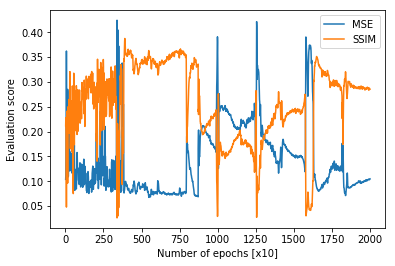

In [5]:
from itertools import zip_longest
s=xx[1].str.strip("()").str.split(',')
lol=pd.DataFrame.from_records(zip_longest(*s.values)).T
lol.columns = ['MSE', 'SSIM']
lol=lol.astype('float')
lol.rolling(3).mean().plot()
plt.xlabel('Number of epochs [x10]')
plt.ylabel('Evaluation score')

In [6]:
ddd = pd.read_csv('experiments/20190130-121209/DropoutGAN(learn_rate=0.0001,_beta_1=0.9,_**config)/d_loss.csv', header=None)

In [7]:
ggg = pd.read_csv('experiments/20190130-121209/DropoutGAN(learn_rate=0.0001,_beta_1=0.9,_**config)/g_loss.csv', header=None)

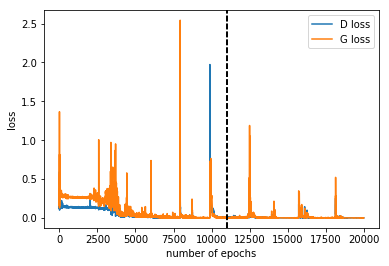

In [9]:
plt.plot(ddd.values[4::, 0], ddd.values[4::, 1], label = 'D loss')
plt.plot(ggg.values[4::, 0], ggg.values[4::, 1], label = 'G loss')
plt.axvline(x=11008, color='black', linestyle='dashed')
plt.axvline(x=11020, color='black', linestyle='dashed')
plt.axvline(x=11035, color='black', linestyle='dashed')
plt.xlabel('number of epochs')
plt.ylabel('loss')
plt.legend()
#plt.plot(ggg.values[5::, 0], vv[5::])
#plt.show()
#plt.savefig('experiments/20181201-180730/DropoutGAN(learn_rate=0.0001,_beta_1=0.9,_**config)/losses.png')

In [ ]:
len(ggg.values[:, 0])

In [ ]:
vv = (np.ones(1500)*0.26)

In [ ]:
(ggg.values[5::, 1])

def evaluate(self, X_low_dim, scorers, epochs):
    X = np.expand_dims(X_low_dim, axis=3)
    X_train, X_test = train_test_split(X)
    start_time = time.clock()
    idx = np.random.randint(0, X_train.shape[0], 6)
    imgs = X_train[idx]
    self.sample_images(imgs,self.folder_name())
    self.save_model(self.folder_name())

    score = {scorer.__name__ : scorer(self, X_test) for scorer in scorers}
    print(time.clock() - start_time, "seconds")
    return score
results = {model:evaluate(model,X_train, scorers=scorers, epochs=epochs) for model in models}
#results = {model: 5 for model in models}
#pprint("Score on test set per parameter setting")
#pprint(results)

In [ ]:
import shutil
#shutil.rmtree('experiments/20190116-194320/')

In [ ]:
X_train = np.load('data/slike/healthy-axis2-slice100_x_train.npy')